# Group 17: Curt Ginder, Mondira Ray, Nikita Bedi, Ozzie Unlu


# Contributors

- [@cginder](https://github.com/cginder)
- [@mondira17](https://github.com/mondira17)
- [@ounlu](https://github.com/ounlu)
- [@nikita-bedi](https://github.com/nikita-bedi)

#Introduction and Problem Statement:

Electrocardiograms (ECGs) are commonly performed procedures to detect and screen for heart abnormalities; over 10 million ECGs are performed annually in the United States.[1] ECG interpretation is challenging even for experienced healthcare professionals; manual ECG reading accuracy has been shown to be around 45-60% among non-cardiology healthcare professionals and about 50% in physicians.[2,3]

The goal of this project is to develop machine learning models capable of automated multilabel ECG classification—predicting the presence of multiple cardiac diagnoses directly from raw waveform data.


Dataset

This study utilizes data from the MIMIC-IV-ECG, dataset available through
PhysioNet. The overall size of this database is 90GB (33GB compressed), representing 800,000 electrocardiograms from 160,000 patients. For ease of collaboration and scalability, we stored the data in a shared Google Drive folder and a Google Cloud Platform (GCP) bucket.
The dataset includes three main components:
* ECG waveform data (‘record df‘), which contains raw voltage-time signals from clinical settings including inpatient, outpatient, and emergency
department visits.
* Machine-generated measurements (‘measure df‘), such as RR interval,
QRS duration, and QTc interval, automatically extracted by ECG
devices and stored in ‘machine measurements‘.
* Diagnostic labels and outcomes (‘outcomes df‘), including ICD-10
codes and mortality information, stored in ‘records w diag icd10‘.



# EDA Insights
Our exploratory data analysis (EDA) was crucial for shaping the direction and design of our modeling pipeline. We focused on understanding the structure, quality, and challenges inherent in the MIMIC-IV-ECG dataset, leading to several key findings and decisions:


We discovered that while most subjects had only a few ECGs, a small minority had dozens or even hundreds (up to 260 ECGs).
To avoid data leakage and prevent overfitting to certain patients, we decided to subject-level train/validation/test splits rather than random ECG splits.








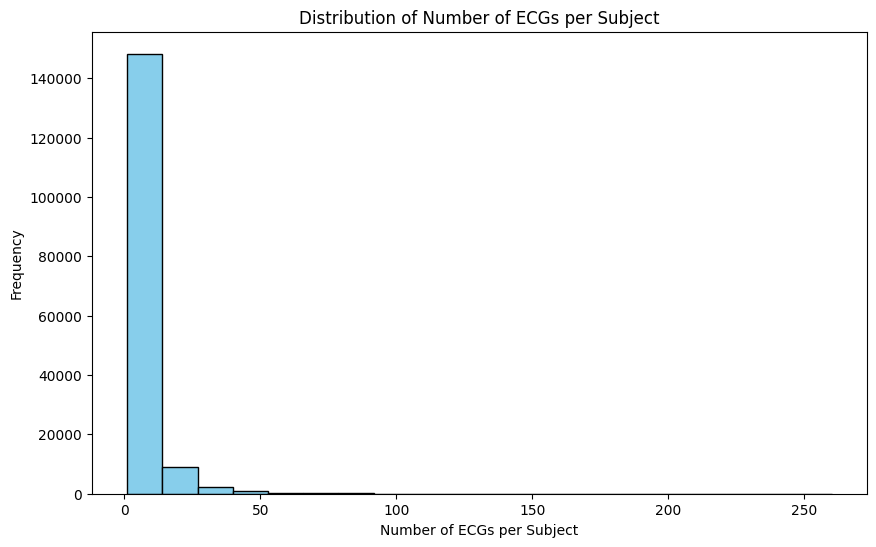

Figure 1. The above figure displays the number of unique ECGs per patient in the MIMIC-IV dataset. The vast majority of patients have < 10 ECGs while there is a wide tail, with a handful of patients having more than 250 ECGs.

## Clinical Layout Reconstruction:
Raw waveform data do not match the appearance of printed ECGs that we see in clinic. Thus, we designed a preprocessing step to mimic the clinical printed format, improving interpretability and potential for future use.
We also looked at missing data and empty ECG signals as well, and decided to replace NaNs with zeros.  

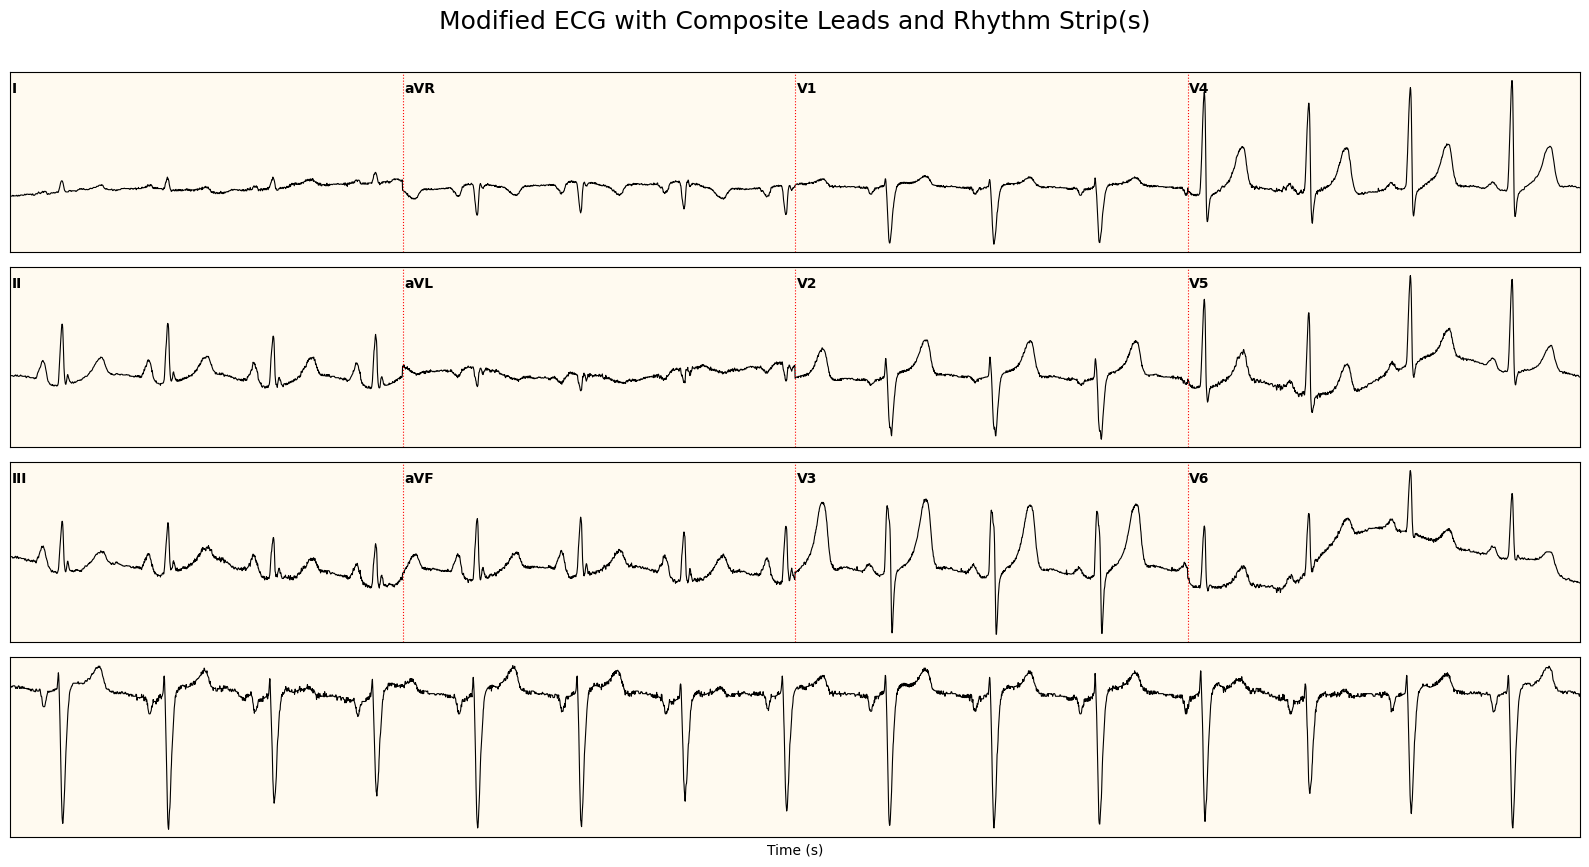

Figure 2. Example MIMIC-ECG waveform data modified and presented in the format typically used in clinical practice.

Mortality Data Incompleteness:

Initially, we considered predicting mortality. However, outcome labels were often missing or not directly linked to ECG events.
We shifted our modeling focus to ECG waveform interpretation and diagnostic label classification instead.

We standardized and categorized thousands of raw text phrases from the reports generated from ECGs, consolidating similar descriptions and mapping them to consistent clinical findings such as rhythm or infarction type. Subsequently, we applied this logic to individual ECG records, aggregating multiple report lines per ECG and using prioritization rules to generate a final, ML-ready label for each key finding without missing values. Building upon this standardized data, we then mapped the consolidated final labels for each ECG record to our specific target machine learning variables. This involved converting detailed findings into binary (yes/no) indicators for conditions like Afib, LBBB, and LVH, and creating simplified categorical outputs for others such as Ischemia (Normal vs. Other) and Voltage (Low vs. Normal/High). We noticed that there was quite a class imbalance, and some correlation between these features as well.

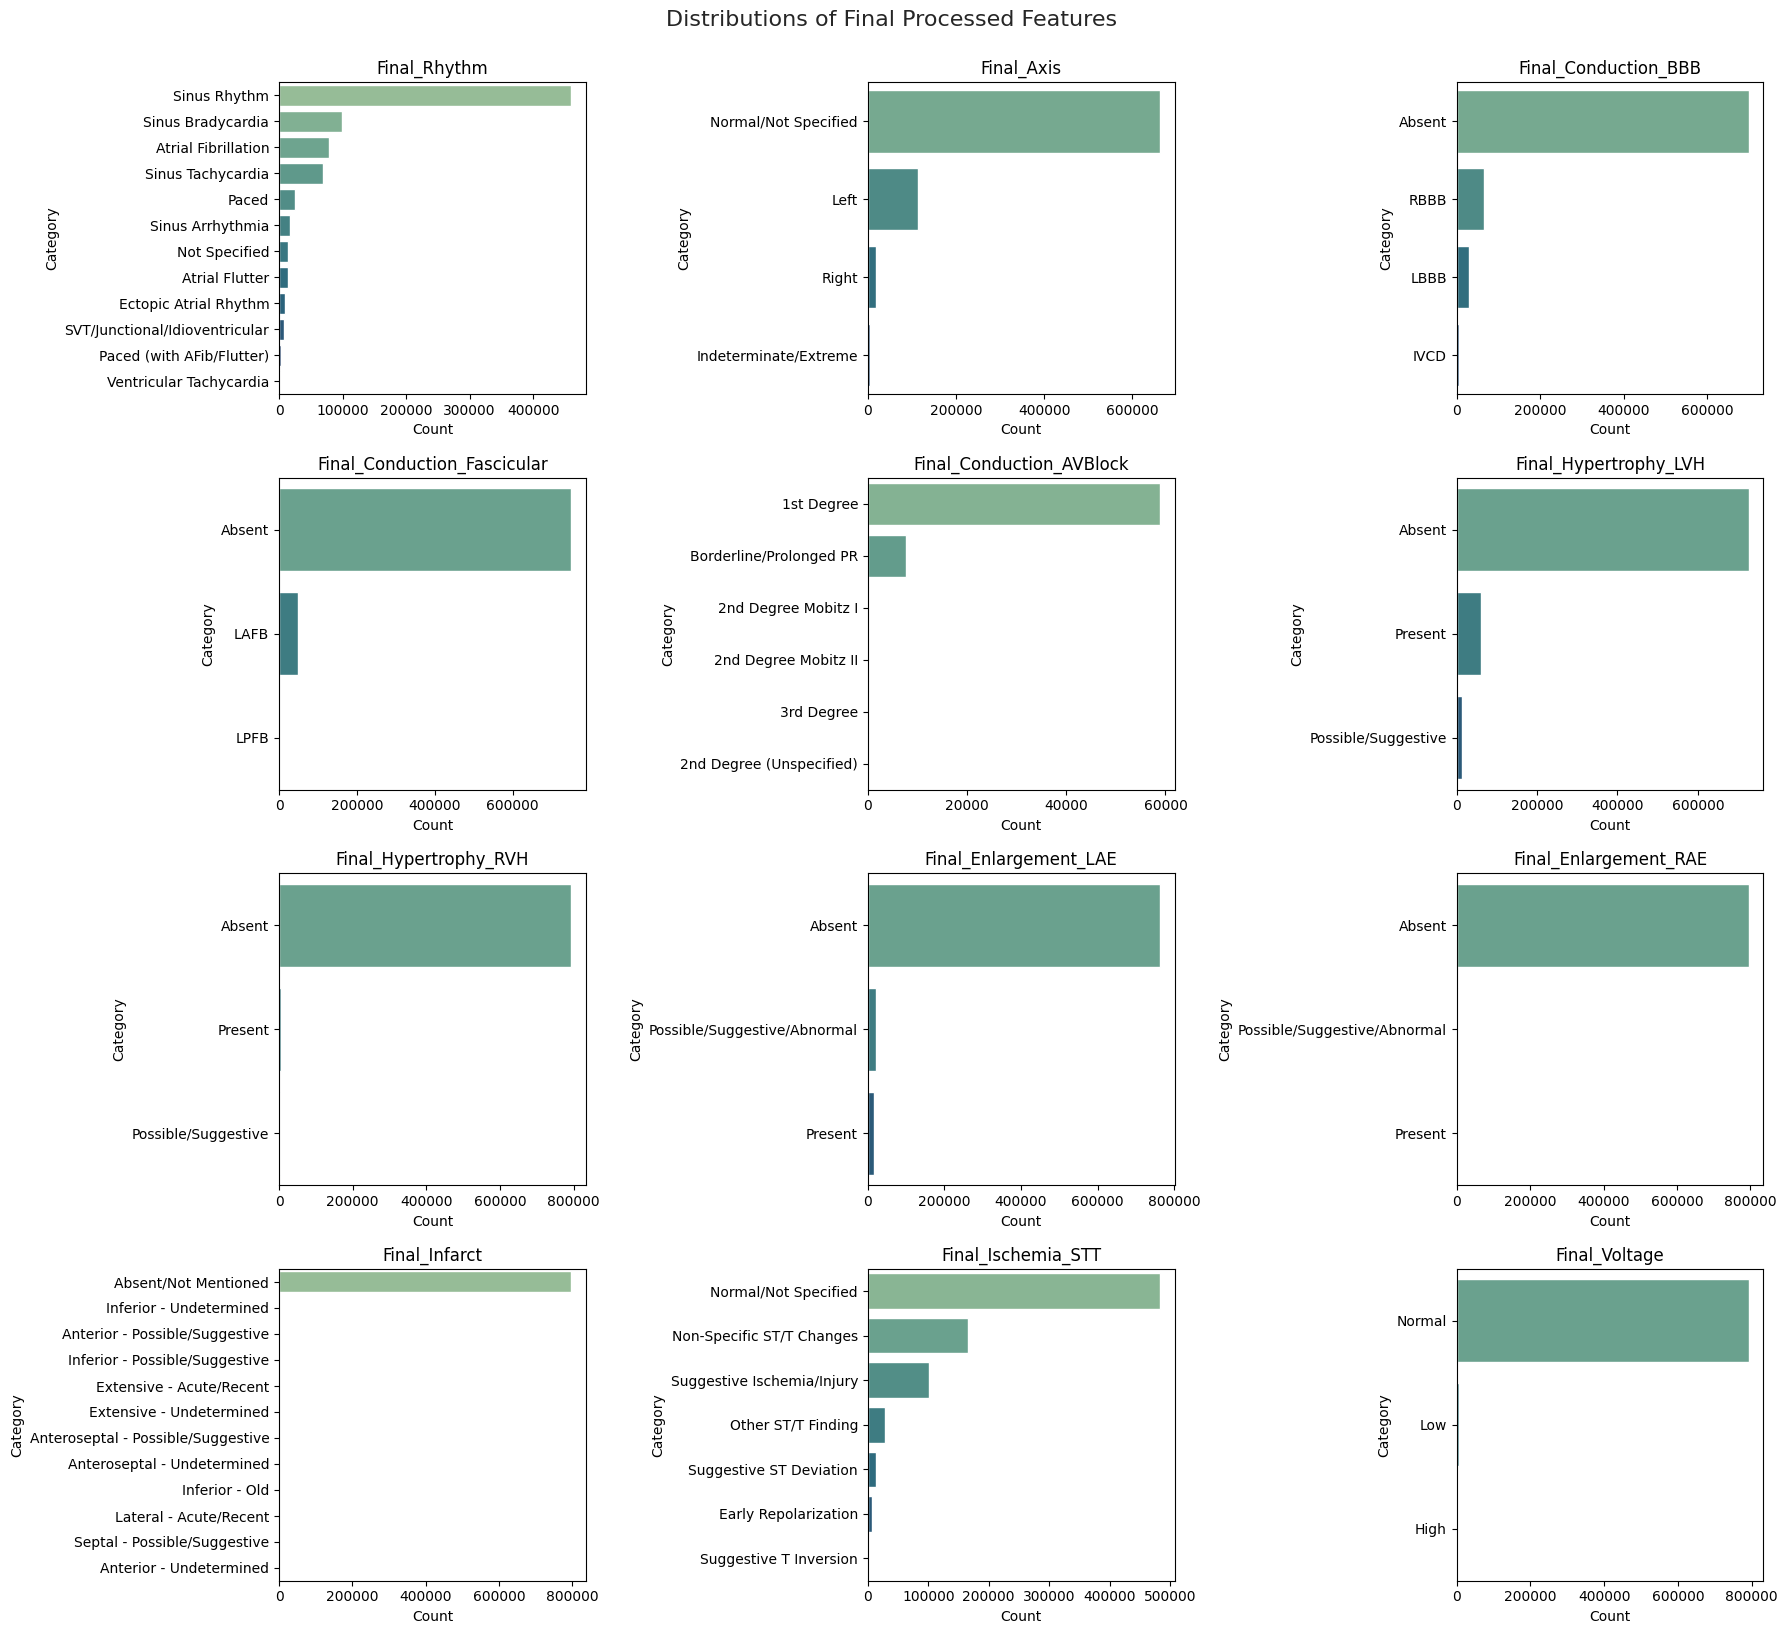

Figure 3. Distribution of unique labels. This figure shows the underlying potential labels any one ECG can contain. Labels within each plot and class grouping are mutually exclusive.

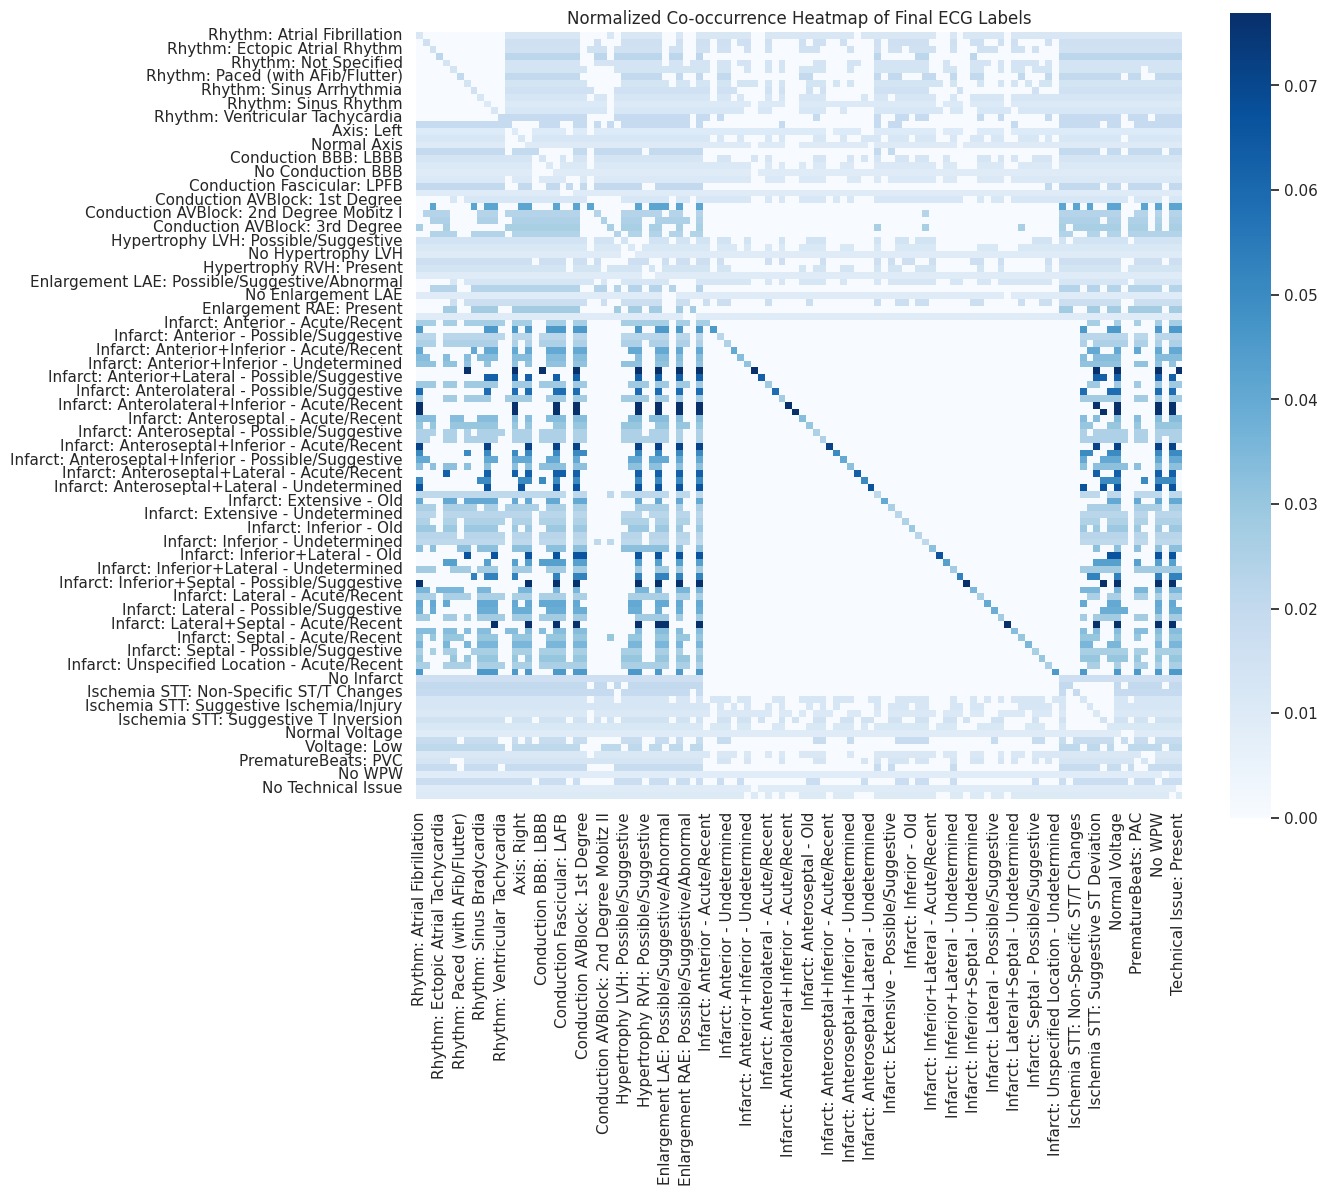

Figure 4. The row-normalized co-occurrence matrix illustrates the proportion of times each diagnostic label is observed in combination with others. Diagonal values vary in intensity, indicating that some labels appear mostly in isolation (e.g., “Normal Rhythm”), while others (e.g., infarct patterns or ischemic changes) frequently co-occur. This matrix confirms that certain ECG pathologies, such as multi-territory infarctions or combined conduction + rhythm disturbances, are clinically interrelated. However, this visualization also highlights that the majority of ECGs are not cleanly classifiable into a single label, reinforcing the need for flexible, anomaly-aware modeling.

## EDA conclusion:

Through EDA, we refined and mapped the machine outputs and reports into a curated set of 16 binary diagnostic labels, covering common and clinically relevant cardiac abnormalities (e.g., Atrial Fibrillation, LBBB, etc.).

Each ECG after our EDA and processing of the dataset finally has:
* An input: 5000 samples × 4 channels (leads)
* A target output: 16 binary labels



# Libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, balanced_accuracy_score, precision_recall_curve
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, Dropout, Cropping1D, GlobalAveragePooling1D, Dense, Flatten
import pickle
import pandas as pd
import pandas as pd
import numpy as np
import h5py
import glob
import json
import re
import collections
import torch
import torch.nn as nn

In [ ]:
#gdrive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/AC209B/PROCESSED_DATA/Standard_Multilabel/ecg_standard_multilabel_TFR.zip /content/

!unzip /content/ecg_standard_multilabel_TFR.zip

Archive:  /content/ecg_standard_multilabel_TFR.zip
   creating: upload/
  inflating: upload/.DS_Store        
  inflating: __MACOSX/upload/._.DS_Store  
  inflating: upload/train.tfrecord   
  inflating: __MACOSX/upload/._train.tfrecord  
  inflating: upload/val.tfrecord     
  inflating: __MACOSX/upload/._val.tfrecord  


# Baseline Model

Our exploratory data analysis showed that certain labels (e.g., RBBB, LBBB) are much more prevalent than rare classes (e.g., RVH, PAC), highlighting significant class imbalance. As a result, we emphasized loss functions that handle imbalance, such as weighted binary cross-entropy.



For our baseline models, we selected two architectures:


1. Autoencoder + CNN Classifier

We built a 1D Convolutional Neural Network (CNN) based autoencoder followed by a classification head.
We chose this model for its simplicity and flexibility:

* 	The encoder learns compressed, low-dimensional representations of the ECG waveform, capturing global structural patterns (e.g., overall rhythm, heart rate variability).
*   The classification head — composed of CNN and dense layers — focuses on local features such as sharp waveform deflections, ST-segment shifts, or P-wave abnormalities, critical for fine-grained diagnosis.

This approach balances global and local learning, which is well-suited for the multilabel nature of ECG interpretation.

2. Vanilla CNN Classifier

In parallel, we also implemented a vanilla 1D CNN classifier without an autoencoder. This model directly processes the raw ECG waveforms through a series of convolutional and pooling layers, culminating in a multilabel classification output.

The Vanilla CNN provides a simpler, more traditional deep learning baseline to compare against the feature compression + classification approach of the Autoencoder model.





## Training Setup
Input

	* Raw ECG signals with shape (5000 samples × 4 channels)

Output

	* Multilabel binary targets (16 diagnostic classes)

Loss Function

	* Weighted Binary Cross-Entropy to handle class imbalance, where rarer labels are upweighted.

Evaluation Metrics

	* Accuracy
	* Area Under the ROC Curve (AUC) — computed per label for fine-grained performance tracking.

Early Stopping:

	* Training is monitored on validation loss with early stopping after patience of several epochs to prevent overfitting.

## Load and preprocess training and validation datasets

In [ ]:
TRAIN_TFRECORD = '/content/upload/train.tfrecord'
VAL_TFRECORD = '/content/upload/val.tfrecord'

LABEL_COLUMNS = [
    'Afib', 'Aflutter', 'Left_axis', 'Right_axis', 'RBBB', 'LBBB',
    'LAFB', 'First_Degree_AVB', 'LVH', 'RVH', 'LAE', 'RAE',
    'Final_Ischemia', 'PAC', 'PVC', 'Voltage'
]
BATCH_SIZE = 1024

def parse_tfrecord(example_proto):
    feature_description = {
        'signal': tf.io.FixedLenFeature([], tf.string),
        'labels': tf.io.FixedLenFeature([len(LABEL_COLUMNS)], tf.float32),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    signal = tf.io.decode_raw(example['signal'], tf.float32)
    signal = tf.reshape(signal, [5000, 4])
    return signal, example['labels']

def make_tfrecord_dataset(tfrecord_path, batch_size=BATCH_SIZE, shuffle=False, repeat=False):
    if not os.path.exists(tfrecord_path):
        raise FileNotFoundError(f'TFRecord file not found: {tfrecord_path}')
    raw_ds = tf.data.TFRecordDataset(tfrecord_path)
    ds = raw_ds.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(4096)
    ds = ds.batch(batch_size)
    if repeat:
        ds = ds.repeat()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

def get_all_labels_from_tfrecord(tfrecord_path, batch_size=4096):
    labels_list = []
    raw_ds = tf.data.TFRecordDataset(tfrecord_path)
    parsed_ds = raw_ds.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    parsed_ds = parsed_ds.batch(batch_size)
    for _, batch_labels in parsed_ds:
        labels_list.append(batch_labels.numpy())
    labels_array = np.concatenate(labels_list, axis=0)
    return labels_array

train_labels = get_all_labels_from_tfrecord(TRAIN_TFRECORD)
val_labels = get_all_labels_from_tfrecord(VAL_TFRECORD)
print('train_labels shape:', train_labels.shape)
print('val_labels shape:', val_labels.shape)

class_counts = train_labels.sum(axis=0)
class_freqs = class_counts / len(train_labels)
class_weights = 1.0 / (class_freqs + 1e-6)
class_weights = np.log(class_weights + 1)
class_weights = np.clip(class_weights, 1, 20)
class_weights_tf = tf.constant(class_weights, dtype=tf.float32)


train_labels shape: (351351, 16)
val_labels shape: (117601, 16)


## Custom Loss Function to account for the multiclass imbalance

In [ ]:
def weighted_binary_crossentropy(class_weights):
    def loss_fn(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        weights_per_label = class_weights * y_true
        weights_sum = tf.reduce_sum(weights_per_label, axis=-1)
        return bce * weights_sum
    return loss_fn

In [ ]:
loss_fn = weighted_binary_crossentropy(class_weights_tf)

## Function: Train and Save Best Models

This function trains a given model while implementing best practices to improve generalization and avoid overfitting:

- **Early Stopping**:  
  Monitors validation loss and stops training when performance stops improving, preventing unnecessary training and overfitting.

- **Model Checkpointing**:  
  Saves the best version of the model (based on validation loss) during training for future evaluation and deployment.

- **Learning Rate Scheduling**:  
  Reduces the learning rate when the validation loss reaches a plateau, helping the model escape local minima and converge more effectively.

- **Class Imbalance Evaluation**:
  Includes a custom callback that evaluates AUC and AUPRC for each label after every epoch—essential for monitoring model performance across imbalanced classes.




Function to evaluate model performancy using per class AUC due to classs imbalance

In [ ]:
class PerClassAUC(tf.keras.callbacks.Callback):
    def __init__(self, val_data, label_names):
        super().__init__()
        self.val_data = val_data
        self.label_names = label_names

    def on_epoch_end(self, epoch, logs=None):
        y_true, y_pred = [], []
        for x_batch, y_batch in self.val_data:
            y_true.append(y_batch.numpy())
            y_pred.append(self.model.predict(x_batch, verbose=0))
        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)

        for i, label in enumerate(self.label_names):
            try:
                auc = roc_auc_score(y_true[:, i], y_pred[:, i])
                print(f"Epoch {epoch+1} - {label} AUC: {auc:.4f}")
            except:
                print(f"Epoch {epoch+1} - {label} AUC: ERROR")

In [ ]:
def train_and_save(model, train_ds, val_ds, model_name, save_dir='/content/drive/MyDrive/AC209B/MODELS/', epochs=50, steps_per_epoch=None, validation_steps=None):
    os.makedirs(save_dir, exist_ok=True)
    checkpoint_path = os.path.join(save_dir, f'{model_name}_best.keras')
    history_path = os.path.join(save_dir, f'{model_name}_history.pkl')

    checkpoint_cb = ModelCheckpoint(
        checkpoint_path,
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_weights_only=False
    )
    earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.5,
      patience=5,
      min_lr=1e-6,
      verbose=1
    )
    per_class_auc_callback = PerClassAUC(val_data=val_ds, label_names=LABEL_COLUMNS)
    print(f'Model Summary for {model_name}:')
    model.summary()

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[checkpoint_cb, earlystop_cb, reduce_lr, per_class_auc_callback],
        verbose=1
    )

    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

    print(f'Saved model to {checkpoint_path}')
    print(f'Saved training history to {history_path}')
    return history, checkpoint_path

## Function: Model Evaluation

Allows us to evaluate our best models on the same metrics: accuracy, AUCs, false positive rate, and true positive rate for each of the 16 labels.


In [ ]:
def get_optimal_thresholds(y_true, y_probs, metric='f1'):
    thresholds = []
    for i in range(y_true.shape[1]):
        precision, recall, thresh = precision_recall_curve(y_true[:, i], y_probs[:, i])
        if len(thresh) == 0:
            thresholds.append(0.5)  # fallback
            continue
        if metric == 'f1':
            f1 = 2 * precision * recall / (precision + recall + 1e-8)
            best_idx = f1.argmax()
        elif metric == 'bacc':
            preds = [(y_probs[:, i] > t).astype(int) for t in thresh]
            baccs = [balanced_accuracy_score(y_true[:, i], p) for p in preds]
            best_idx = np.argmax(baccs)
        thresholds.append(thresh[best_idx])
    return np.array(thresholds)

def evaluate_model(model, test_ds, label_names, threshold_metric='f1'):
    y_true, y_probs = [], []

    for x_batch, y_batch in test_ds:
        y_true.append(y_batch.numpy())
        y_probs.append(model.predict(x_batch, verbose=0))

    y_true = np.concatenate(y_true, axis=0)
    y_probs = np.concatenate(y_probs, axis=0)

    optimal_thresholds = get_optimal_thresholds(y_true, y_probs, metric=threshold_metric)
    y_pred = (y_probs > optimal_thresholds[np.newaxis, :]).astype(int)

    aucs, auprcs, baccs = [], [], []
    fpr_dict, tpr_dict = {}, {}

    for i, label in enumerate(label_names):
        try:
            auc = roc_auc_score(y_true[:, i], y_probs[:, i])
            auprc = average_precision_score(y_true[:, i], y_probs[:, i])
            bacc = balanced_accuracy_score(y_true[:, i], y_pred[:, i])
            fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
        except:
            auc, auprc, bacc, fpr, tpr = float('nan'), float('nan'), float('nan'), None, None

        aucs.append(auc)
        auprcs.append(auprc)
        baccs.append(bacc)
        fpr_dict[label] = fpr
        tpr_dict[label] = tpr

        print(f"{label:<20} AUC: {auc:.4f}  AUPRC: {auprc:.4f}  BAcc: {bacc:.4f}  Thresh: {optimal_thresholds[i]:.2f}")

    return aucs, auprcs, baccs, optimal_thresholds, fpr_dict, tpr_dict, y_true, y_pred, y_probs

In [ ]:
NUM_TRAIN_SAMPLES = len(train_labels)
NUM_VAL_SAMPLES = len(val_labels)
BATCH_SIZE = 1024

steps_per_epoch = NUM_TRAIN_SAMPLES // BATCH_SIZE
validation_steps = NUM_VAL_SAMPLES // BATCH_SIZE


Helper function to visualize training history including training loss, validation loss, accuracy, and AUC over epochs.

In [ ]:
def plot_training_history(history_path):
    with open(history_path, 'rb') as f:
        history = pickle.load(f)

    print(f"Metrics in history: {list(history.keys())}\n")

    # Always plot loss
    plt.figure(figsize=(8, 5))
    plt.plot(history['loss'], label='Train Loss')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot all other metrics that have val_* counterparts
    for key in history:
        if key.startswith('val_') and key != 'val_loss':
            metric = key.replace('val_', '')
            if metric in history:
                plt.figure(figsize=(8, 5))
                plt.plot(history[metric], label=f'Train {metric}')
                plt.plot(history[key], label=f'Val {metric}')
                plt.title(f'{metric.capitalize()} Over Epochs')
                plt.xlabel('Epoch')
                plt.ylabel(metric.capitalize())
                plt.legend()
                plt.grid(True)
                plt.show()

## Baseline Model 1: Autoencoder + CNN


In [ ]:
def build_4lead_autoencoder(input_length=5000, n_channels=4):
    lr = 1e-3
    input_signal = Input(shape=(input_length, n_channels))

    # --- Encoder ---
    x = Conv1D(128, 9, activation='relu', padding='same')(input_signal)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(0.15)(x)

    x = Conv1D(64, 7, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(0.15)(x)

    x = Conv1D(32, 5, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(0.10)(x)

    x = Conv1D(16, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(0.10)(x)

    x = Conv1D(8, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling1D(2, padding='same', name='bottleneck')(x)

    # --- Decoder ---
    x = Conv1D(8, 3, activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = UpSampling1D(2)(x)

    x = Conv1D(16, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling1D(2)(x)

    x = Conv1D(32, 5, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling1D(2)(x)

    x = Conv1D(64, 7, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling1D(2)(x)

    x = Conv1D(128, 9, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling1D(2)(x)

    decoded = Conv1D(n_channels, 3, activation='linear', padding='same')(x)

    # Crop if needed
    crop = int(decoded.shape[1] - input_length)
    if crop > 0:
        decoded = Cropping1D((0, crop))(decoded)

    autoencoder = Model(inputs=input_signal, outputs=decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    # Extract encoder (up to bottleneck)
    encoder = Model(inputs=input_signal, outputs=encoded)

    return autoencoder, encoder

In [ ]:
autoencoder, encoder = build_4lead_autoencoder(5000, 4)
print('Autoencoder Model Summary:')
autoencoder.summary()
train_ds_ae = (
    make_tfrecord_dataset(TRAIN_TFRECORD, BATCH_SIZE, shuffle=True)
    .map(lambda x, y: (x, x))
    .prefetch(tf.data.AUTOTUNE)
    .repeat()
)

val_ds_ae = (
    make_tfrecord_dataset(VAL_TFRECORD, BATCH_SIZE)
    .map(lambda x, y: (x, x))
    .prefetch(tf.data.AUTOTUNE)
    .repeat()
)

checkpoint_cb = ModelCheckpoint(
    filepath='/content/drive/MyDrive/AC209B/MODELS/standard_autoencoder_best.keras',  # Save path
    monitor='val_loss',
    save_best_only=True,      # Save only the best model (not every epoch)
    mode='min',
    verbose=1,
    save_weights_only=False
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

autoencoder.fit(
    train_ds_ae,
    validation_data=val_ds_ae,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint_cb, earlystop_cb, lr_scheduler]
)


Autoencoder Model Summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5000, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 5000, 128)      │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5000, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2500, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 2500, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2500, 64)       │        57,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2500, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1250, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1250, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1250, 32)       │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1250, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 625, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 625, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 625, 16)        │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 625, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 313, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 313, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 313, 8)         │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 313, 8)         │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (MaxPooling1D)       │ (None, 157, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 157, 8)         │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 157, 8)         │            32 │
│ (BatchNormalization)            │                        │             

 Total params: 169,332 (661.45 KB)

 Trainable params: 168,340 (657.58 KB)

 Non-trainable params: 992 (3.88 KB)

Epoch 1/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.1593
Epoch 1: val_loss improved from inf to 0.02991, saving model to /content/drive/MyDrive/AC209B/MODELS/standard_autoencoder_best.keras
343/343 ━━━━━━━━━━━━━━━━━━━━ 136s 283ms/step - loss: 0.1590 - val_loss: 0.0299 - learning_rate: 0.0010
Epoch 2/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.0147
Epoch 2: val_loss improved from 0.02991 to 0.01191, saving model to /content/drive/MyDrive/AC209B/MODELS/standard_autoencoder_best.keras
343/343 ━━━━━━━━━━━━━━━━━━━━ 106s 276ms/step - loss: 0.0146 - val_loss: 0.0119 - learning_rate: 0.0010
Epoch 3/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.0109
Epoch 3: val_loss improved from 0.01191 to 0.00862, saving model to /content/drive/MyDrive/AC209B/MODELS/standard_autoencoder_best.keras
343/343 ━━━━━━━━━━━━━━━━━━━━ 95s 276ms/step - loss: 0.0109 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 4/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.0089
Epoch 4: 

In [ ]:
#save encoder
encoder.save('/content/drive/MyDrive/AC209B/MODELS/enoder_classifier_best.keras')

In [ ]:
#load encoder
encoder = tf.keras.models.load_model('/content/drive/MyDrive/AC209B/MODELS/enoder_classifier_best.keras')

In [ ]:
encoder.trainable=True

def build_encoder_classifier(
    encoder,
    num_classes=16,
    hidden_dims=(512, 256, 128),
    dropout_rate=0.3,
    learning_rate=1e-4
):
    """
    Build a multilabel classifier on top of the frozen or fine-tuned encoder.
    """

    x = encoder.output

    # Global pooling over time axis
    x = GlobalAveragePooling1D(name='avg_pool')(x)

    # Normalize features
    x = BatchNormalization(name='bn_pool')(x)

    # Deep MLP head
    for i, dim in enumerate(hidden_dims):
        x = Dense(dim, activation='relu', name=f'dense_{i+1}')(x)
        x = Dropout(dropout_rate, name=f'dropout_{i+1}')(x)

    # Final multilabel output
    outputs = Dense(num_classes, activation='sigmoid', name='output')(x)

    # Final model
    model = Model(inputs=encoder.input, outputs=outputs, name='encoder_classifier')

    # Compile
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss_fn,  # weighted focal loss
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(multi_label=True, name='auc')
        ]
    )

    return model

In [ ]:
history_encoder, _ = train_and_save(
    build_encoder_classifier(encoder),
    make_tfrecord_dataset(TRAIN_TFRECORD, BATCH_SIZE, shuffle=True, repeat=True),
    make_tfrecord_dataset(VAL_TFRECORD, BATCH_SIZE, repeat=False),
    model_name='enoder_classifer',
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


Model Summary for enoder_classifer:


Model: "encoder_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5000, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 5000, 128)      │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5000, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2500, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 2500, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2500, 64)       │        57,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2500, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1250, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1250, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1250, 32)       │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1250, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 625, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 625, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 625, 16)        │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 625, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 313, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 313, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 313, 8)         │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 313, 8)         │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (MaxPooling1D)       │ (None, 157, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 8)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_pool (BatchNormalization)    │ (None, 8)              │            3

 Total params: 246,280 (962.03 KB)

 Trainable params: 245,768 (960.03 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.1821 - auc: 0.5543 - loss: 1.3165
Epoch 1: val_loss improved from inf to 0.80936, saving model to /content/drive/MyDrive/AC209B/MODELS/enoder_classifer_best.keras
Epoch 1 - Afib AUC: 0.5778
Epoch 1 - Aflutter AUC: 0.5812
Epoch 1 - Left_axis AUC: 0.9374
Epoch 1 - Right_axis AUC: 0.7848
Epoch 1 - RBBB AUC: 0.9676
Epoch 1 - LBBB AUC: 0.9106
Epoch 1 - LAFB AUC: 0.9541
Epoch 1 - First_Degree_AVB AUC: 0.6319
Epoch 1 - LVH AUC: 0.8983
Epoch 1 - RVH AUC: 0.6482
Epoch 1 - LAE AUC: 0.7726
Epoch 1 - RAE AUC: 0.6869
Epoch 1 - Final_Ischemia AUC: 0.7634
Epoch 1 - PAC AUC: 0.6235
Epoch 1 - PVC AUC: 0.6670
Epoch 1 - Voltage AUC: 0.8658
343/343 ━━━━━━━━━━━━━━━━━━━━ 106s 269ms/step - accuracy: 0.1822 - auc: 0.5545 - loss: 1.3156 - val_accuracy: 0.2162 - val_auc: 0.7653 - val_loss: 0.8094 - learning_rate: 1.0000e-04
Epoch 2/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.2749 - auc: 0.7445 - loss: 0.8300
Epoch 2: val_loss im

Metrics in history: ['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss', 'learning_rate']



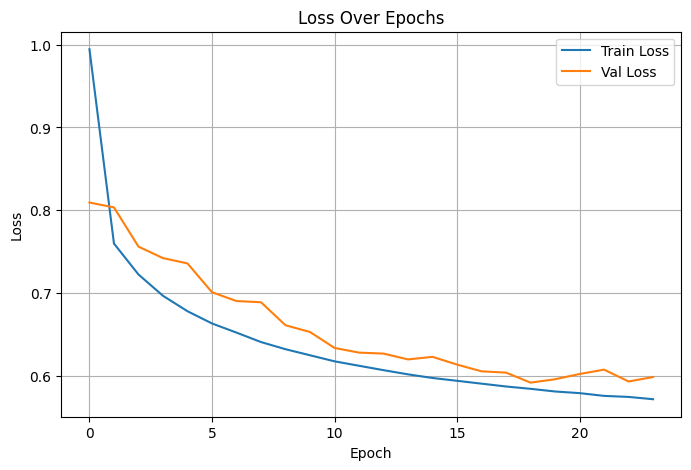

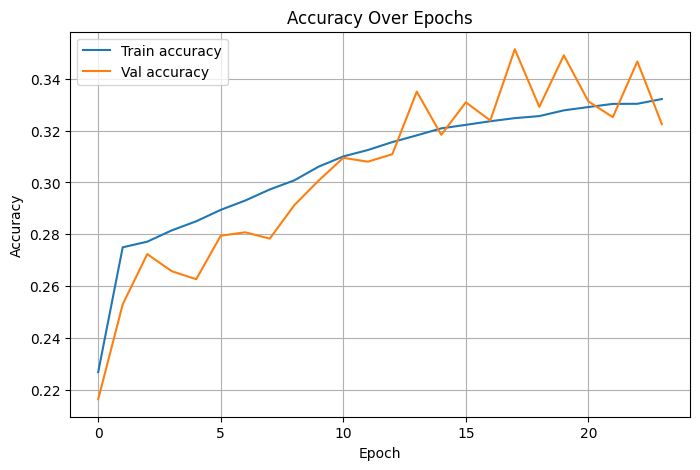

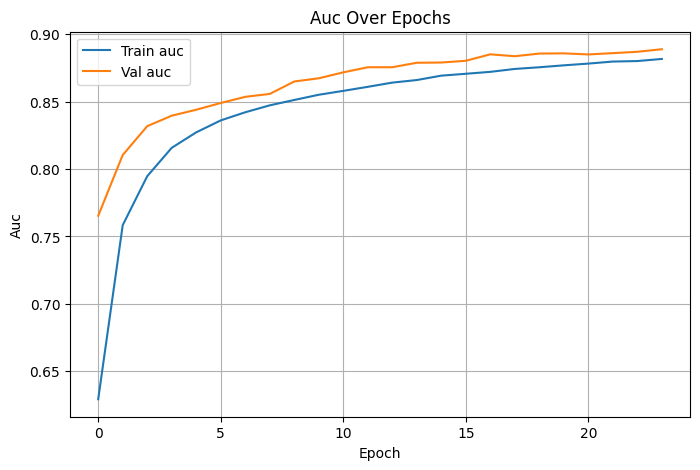

In [ ]:
plot_training_history('/content/drive/MyDrive/AC209B/MODELS/enoder_classifer_history.pkl')

Figure 5.1. Model loss, accuracy, and AUC values by epoch, stratified by training and validation cohorts of our encoder classifier.

## Baseline Model 2: CNN Baseline Model

In [ ]:
# CNN model for multi-lead input (5000, 4)
def build_multilabel_cnn_classifier(input_length=5000, num_classes=16, num_channels=4):
    input_signal = Input(shape=(input_length, num_channels))
    x = Conv1D(32, 7, activation='relu', padding='same')(input_signal)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.15)(x)

    x = Conv1D(64, 5, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.15)(x)

    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.15)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.10)(x)
    output = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs=input_signal, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=weighted_bce_tf,
        metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True)]
    )
    return model

In [ ]:
steps_per_epoch = len(train_labels) // BATCH_SIZE
validation_steps = len(val_labels) // BATCH_SIZE

per_class_auc_callback = PerClassAUC(val_data=val_ds, label_names=LABEL_COLUMNS)

cnn_model = build_multilabel_cnn_classifier(
    input_length=5000,
    num_classes=len(LABEL_COLUMNS),
    num_channels=4
)

cnn_history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, checkpoint, per_class_auc_callback],
    verbose=1
)



In [ ]:
#performance eval
y_true = []
y_pred_cnn = []

for X_batch, y_batch in val_ds:
    y_true.append(y_batch.numpy())
    y_pred_cnn.append(cnn_model.predict(X_batch, verbose=0))

y_true = np.concatenate(y_true, axis=0)
y_pred_cnn = np.concatenate(y_pred_cnn, axis=0)

print("Shapes:", y_true.shape, y_pred_cnn.shape)  # (n_samples, n_classes)

#AUROC per class
aucs = []
for i, label in enumerate(LABEL_COLUMNS):
    try:
        auc = roc_auc_score(y_true[:, i], y_pred_cnn[:, i])
    except ValueError:
        auc = np.nan
    aucs.append(auc)
    print(f"AUC for {label}: {auc:.4f}")

#Macro and Micro AUROC
try:
    macro_auc = roc_auc_score(y_true, y_pred_cnn, average="macro")
    micro_auc = roc_auc_score(y_true, y_pred_cnn, average="micro")
    print(f"Macro AUROC: {macro_auc:.4f}")
    print(f"Micro AUROC: {micro_auc:.4f}")
except Exception as e:
    print("Macro/Micro AUROC error:", e)

In [ ]:
cnn_model= tf.keras.models.load_model(
    '/content/drive/MyDrive/AC209B/MODELS/best_standard_ecg_cnn_classifier.keras',
    custom_objects={'weighted_bce_tf': weighted_binary_crossentropy(class_weights_tf)}
)

Metrics in history: ['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss', 'val_auc_Afib', 'val_auc_Aflutter', 'val_auc_Left_axis', 'val_auc_Right_axis', 'val_auc_RBBB', 'val_auc_LBBB', 'val_auc_LAFB', 'val_auc_First_Degree_AVB', 'val_auc_LVH', 'val_auc_RVH', 'val_auc_LAE', 'val_auc_RAE', 'val_auc_Final_Ischemia', 'val_auc_PAC', 'val_auc_PVC', 'val_auc_Voltage']



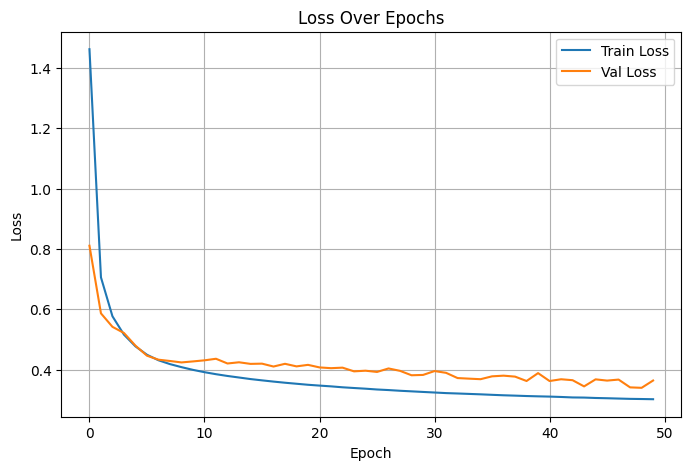

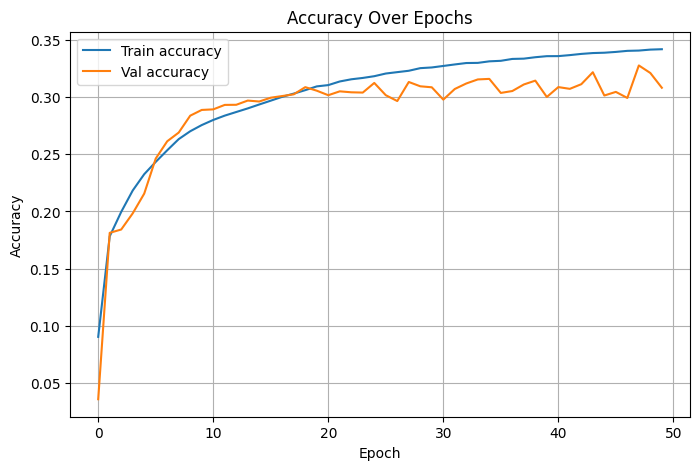

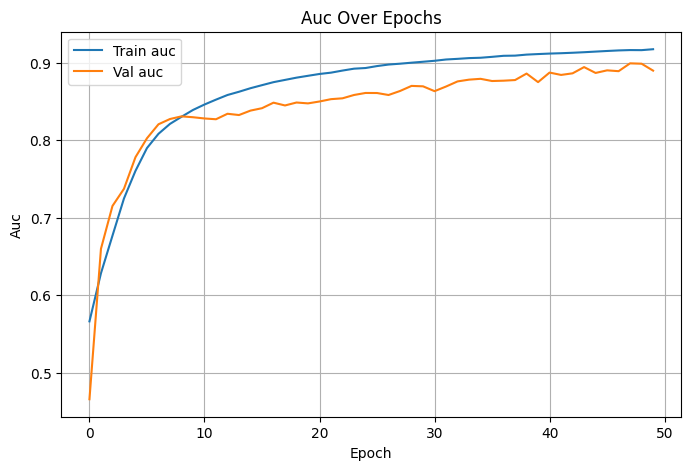

In [ ]:
plot_training_history('/content/drive/MyDrive/AC209B/MODELS/cnn_history.pkl')

Figure 5.2. CNN Baseline model loss, accuracy, and AUC values by epoch, stratified by training and validation cohorts.

# Additional Models

## CNN-LSTM Hybrid


In [ ]:
def build_cnn_lstm_model(input_shape=(5000, 4), n_classes=16, cnn_filters=32, lstm_units=64, dropout=0.3):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(cnn_filters, kernel_size=7, strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(cnn_filters * 2, kernel_size=5, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LSTM(lstm_units, return_sequences=False)(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(n_classes, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True, name='auc')]
    )
    return model

cnn_lstm_model = build_cnn_lstm_model(input_shape=(5000, 4), n_classes=len(LABEL_COLUMNS))
print('CNN-LSTM Hybrid Model Summary:')
cnn_lstm_model.summary()
cnn_lstm_history, cnn_lstm_ckpt = train_and_save(
    cnn_lstm_model,
    make_tfrecord_dataset(TRAIN_TFRECORD, BATCH_SIZE, shuffle=True, repeat=True),
    make_tfrecord_dataset(VAL_TFRECORD, BATCH_SIZE, repeat=True),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    model_name='cnn_lstm_hybrid',
    epochs=50
)


In [ ]:
print('\nPer-label AUC and Accuracy for CNN-LSTM Hybrid Model:')
cnn_lstm_aucs, cnn_lstm_accs, cnn_lstm_fpr, cnn_lstm_tpr, _, _ = evaluate_model(cnn_lstm_model, make_tfrecord_dataset(VAL_TFRECORD, BATCH_SIZE), LABEL_COLUMNS)


Metrics in history: ['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss', 'learning_rate']



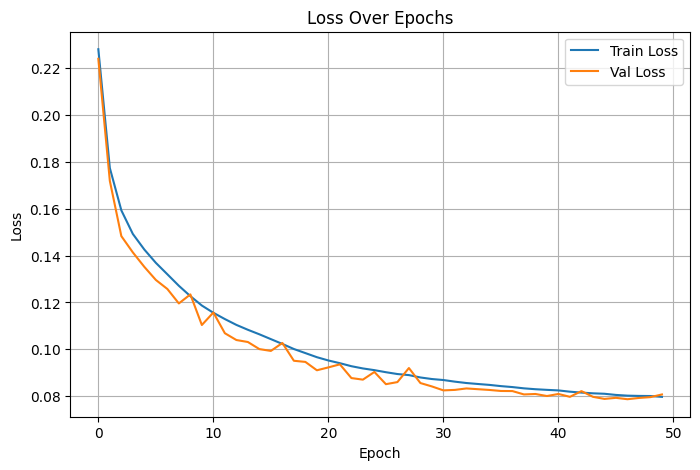

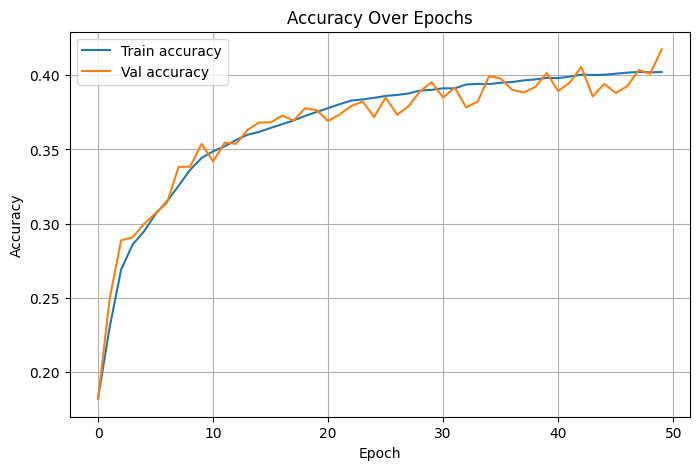

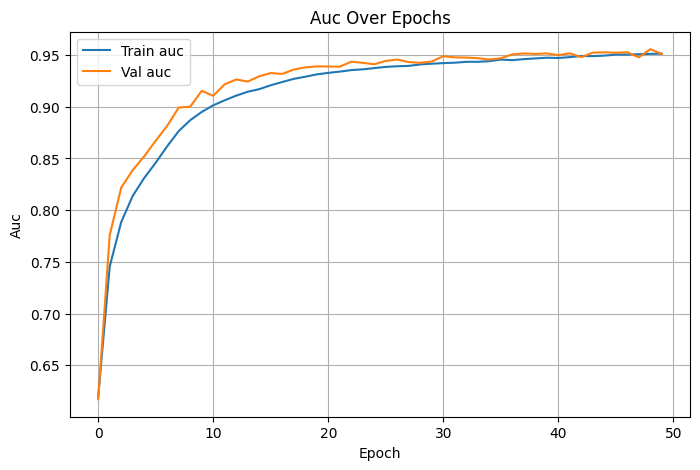

In [ ]:
plot_training_history('/content/drive/MyDrive/AC209B/MODELS/cnn_lstm_hybrid_history.pkl')

Figure 5.3. CNN-LSTM model loss, accuracy, and AUC values by epoch, stratified by training and validation cohorts.

## ResNet1D


In [ ]:
def resnet_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

def build_resnet1d(input_shape=(5000,4), n_classes=16, initial_filters=64, num_blocks=[2, 2, 2], dropout_rate=0.3):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(initial_filters, 7, strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    filters = initial_filters
    for i, blocks in enumerate(num_blocks):
        for b in range(blocks):
            stride = 2 if b == 0 and i > 0 else 1
            x = resnet_block(x, filters, stride=stride)
        filters *= 2
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(n_classes, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True, name='auc')]
    )
    return model

resnet_model = build_resnet1d(input_shape=(5000, 4), n_classes=len(LABEL_COLUMNS))
#print('ResNet1D Model Summary:')
# resnet_model.summary()
resnet_history, resnet_ckpt = train_and_save(
    resnet_model,
    make_tfrecord_dataset(TRAIN_TFRECORD, BATCH_SIZE, repeat=True, shuffle=True),
    make_tfrecord_dataset(VAL_TFRECORD, BATCH_SIZE, repeat=True),
    model_name='resnet1d',
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=50
)

In [ ]:
print('\nPer-label AUC and Accuracy for ResNet1D Model:')
resnet_aucs, resnet_accs, resnet_fpr, resnet_tpr = evaluate_model(resnet_model, make_tfrecord_dataset(VAL_TFRECORD, BATCH_SIZE), LABEL_COLUMNS)


Metrics in history: ['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss', 'learning_rate']



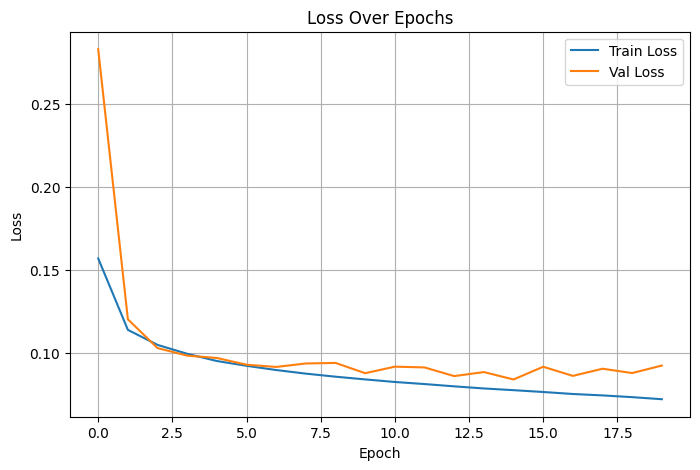

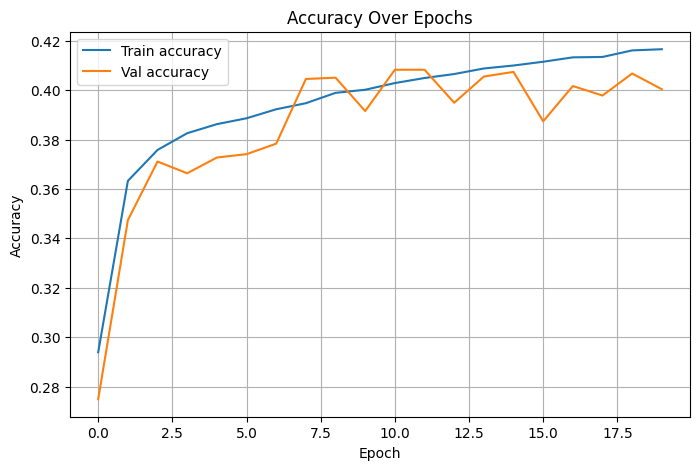

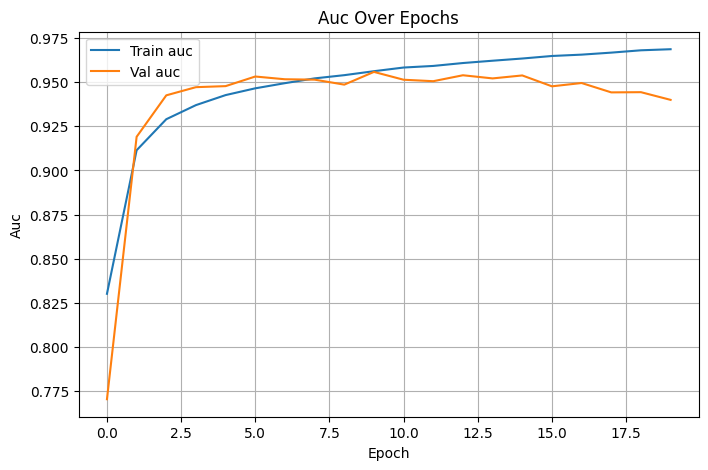

In [ ]:
plot_training_history('/content/drive/MyDrive/AC209B/MODELS/resnet1d_history.pkl')

Figure 5.4. ResNet1D model loss, accuracy, and AUC values by epoch, stratified by training and validation cohorts.

## Tranformer Model


In [ ]:
def build_ecg_transformer_model(
    input_shape=(5000, 4),
    patch_size=50,
    embed_dim=128,
    num_heads=4,
    ff_dim=512,
    num_layers=4,
    num_classes=16,
    dropout_rate=0.1
):
    inputs = tf.keras.Input(shape=input_shape)

    # Create non-overlapping patches
    x = layers.Reshape((input_shape[0] // patch_size, patch_size * input_shape[1]))(inputs)
    x = layers.Dense(embed_dim)(x)

    # Add learnable positional encoding
    pos_encoding = tf.Variable(tf.random.normal([1, x.shape[1], embed_dim]), trainable=True)
    x = x + pos_encoding

    # Transformer blocks
    for _ in range(num_layers):
        # Multi-head attention
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Feedforward block
        ff = layers.Dense(ff_dim, activation='relu')(x)
        ff = layers.Dense(embed_dim)(ff)
        x = layers.Add()([x, ff])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Dropout(dropout_rate)(x)

    # Global pooling and output
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    return models.Model(inputs, outputs)

In [ ]:
# Build transformer model
model = build_ecg_transformer_model(
    input_shape=(5000, 4),
    patch_size=50,
    embed_dim=128,
    num_heads=4,
    ff_dim=512,
    num_layers=4,
    num_classes=len(LABEL_COLUMNS)
)

# Compile with your custom loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss_fn,
    metrics=[tf.keras.metrics.AUC(multi_label=True)]
)

# Create datasets
train_ds = make_tfrecord_dataset(TRAIN_TFRECORD, batch_size=BATCH_SIZE, shuffle=True, repeat=True)
val_ds = make_tfrecord_dataset(VAL_TFRECORD, batch_size=BATCH_SIZE, shuffle=False, repeat=False)

# Train the model
transformer_history, transformer_ckpt = train_and_save(
    model,
    train_ds,
    val_ds,
    model_name='ecg_transformer',
    epochs=100,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Model Summary for ecg_transformer:


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 5000, 4)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 100, 200)  │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 100, 128)  │     25,728 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_54 (Add)        │ (None, 100, 128)  │          0 │ dense_60[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 128)  │    263,808 │ add_54[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_54[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_55 (Add)        │ (None, 100, 128)  │          0 │ add_54[0][0],     │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ add_55[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 100, 512)  │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 100, 128)  │     65,664 │ dense_61[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_56 (Add)        │ (None, 100, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_62[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ add_56[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 100, 128)  │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 128)  │    263,808 │ dropout_53[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_53[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_57 (Add)        │ (None, 100, 128)  │          0 │ dropout_53[0][0], │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ add_57[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 100, 512)  │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 100, 128)  │     65,664 │ dense_63[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_58 (Add)        │ (None, 100, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_64[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ add_58[0][0]      │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 1,611,920 (6.15 MB)

 Trainable params: 1,611,920 (6.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - auc_6: 0.5615 - loss: 1.0412
Epoch 1: val_loss improved from inf to 0.80966, saving model to /content/drive/MyDrive/AC209B/MODELS/ecg_transformer_best.keras
Epoch 1 - Afib AUC: 0.5999
Epoch 1 - Aflutter AUC: 0.4669
Epoch 1 - Left_axis AUC: 0.8686
Epoch 1 - Right_axis AUC: 0.7608
Epoch 1 - RBBB AUC: 0.9257
Epoch 1 - LBBB AUC: 0.9364
Epoch 1 - LAFB AUC: 0.9032
Epoch 1 - First_Degree_AVB AUC: 0.5525
Epoch 1 - LVH AUC: 0.7820
Epoch 1 - RVH AUC: 0.7196
Epoch 1 - LAE AUC: 0.5813
Epoch 1 - RAE AUC: 0.6585
Epoch 1 - Final_Ischemia AUC: 0.5377
Epoch 1 - PAC AUC: 0.6115
Epoch 1 - PVC AUC: 0.7648
Epoch 1 - Voltage AUC: 0.7235
343/343 ━━━━━━━━━━━━━━━━━━━━ 94s 200ms/step - auc_6: 0.5617 - loss: 1.0408 - val_auc_6: 0.7116 - val_loss: 0.8097 - learning_rate: 1.0000e-04
Epoch 2/100
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - auc_6: 0.7306 - loss: 0.8399
Epoch 2: val_loss improved from 0.80966 to 0.74192, saving model to /content/drive/MyDrive/AC2

In [ ]:
print('\nPer-label AUC and Accuracy for Transformer Model:')
transformer_aucs, transformer_accs, transformer_fpr, transformer_tpr, _, _, _ = evaluate_model(model, make_tfrecord_dataset(VAL_TFRECORD, BATCH_SIZE), LABEL_COLUMNS)


Per-label AUC and Accuracy for Transformer Model:
Afib                 AUC: 0.9309  AUPRC: 0.6104  BAcc: 0.7612
Aflutter             AUC: 0.8883  AUPRC: 0.3008  BAcc: 0.6038
Left_axis            AUC: 0.9669  AUPRC: 0.7980  BAcc: 0.8739
Right_axis           AUC: 0.9772  AUPRC: 0.5435  BAcc: 0.8346
RBBB                 AUC: 0.9851  AUPRC: 0.9066  BAcc: 0.9169
LBBB                 AUC: 0.9830  AUPRC: 0.8384  BAcc: 0.8855
LAFB                 AUC: 0.9796  AUPRC: 0.7483  BAcc: 0.8322
First_Degree_AVB     AUC: 0.8851  AUPRC: 0.4398  BAcc: 0.7516
LVH                  AUC: 0.9325  AUPRC: 0.6664  BAcc: 0.8032
RVH                  AUC: 0.9351  AUPRC: 0.2592  BAcc: 0.6190
LAE                  AUC: 0.8638  AUPRC: 0.3627  BAcc: 0.7243
RAE                  AUC: 0.8617  AUPRC: 0.0974  BAcc: 0.5579
Final_Ischemia       AUC: 0.8586  AUPRC: 0.8029  BAcc: 0.7654
PAC                  AUC: 0.6782  AUPRC: 0.2701  BAcc: 0.5874
PVC                  AUC: 0.9288  AUPRC: 0.6039  BAcc: 0.7991
Voltage            

Metrics in history: ['auc_6', 'loss', 'val_auc_6', 'val_loss', 'learning_rate']



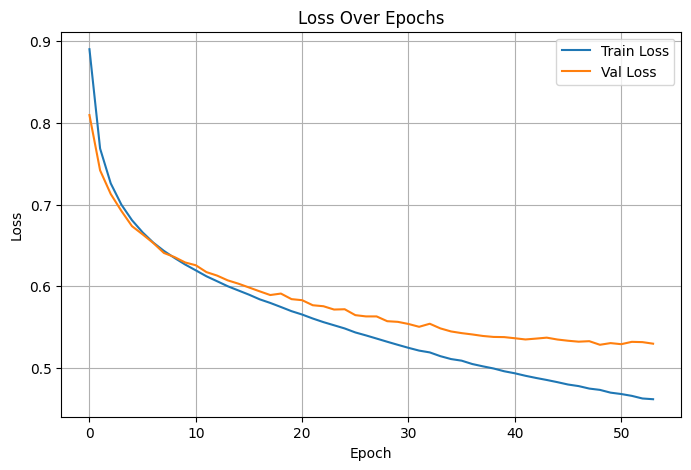

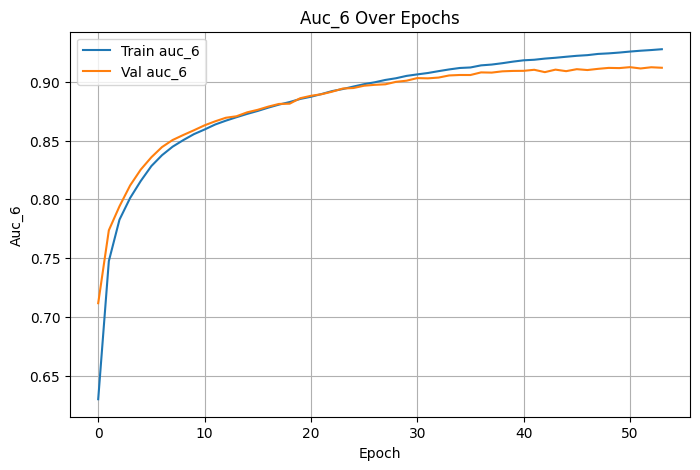

In [ ]:
plot_training_history('/content/drive/MyDrive/AC209B/MODELS/ecg_transformer_history.pkl')

Figure 5.5. Transformer classifier model loss, accuracy, and AUC values by epoch, stratified by training and validation cohorts.

Since the standalone Transformer model underperformed, we explored a hybrid CNN–Transformer architecture, drawing inspiration from [McKeen et al. (2024)](https://arxiv.org/pdf/2408.05178) who proposed a BERT-like encoder combined with convolutional layers for ECG classification.[4] This hybrid design allows CNNs to extract localized waveform features while the Transformer captures long-range dependencies and global rhythm context. We implemented a similar model to assess whether it could improve overall classification performance, particularly for rarer ECG conditions where previous models showed limitations.


## Hybrid CNN-Transformer Model

In [ ]:
def build_hybrid_transformer_model(
    input_shape=(5000, 4),
    patch_size=50,
    embed_dim=128,
    num_heads=4,
    ff_dim=256,
    num_layers=6,
    num_classes=16,
    dropout_rate=0.1
):
    inputs = tf.keras.Input(shape=input_shape)

    # CNN Front-End
    x = layers.Conv1D(64, kernel_size=7, padding='same', activation='relu')(inputs)
    x = layers.Conv1D(128, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Patch Embedding
    num_patches = input_shape[0] // patch_size
    x = layers.Reshape((num_patches, patch_size * 128))(x)
    x = layers.Dense(embed_dim)(x)

    # Positional Encoding (learned)
    pos_encoding = tf.Variable(tf.random.normal([1, num_patches, embed_dim]), trainable=True)
    x = x + pos_encoding

    # Transformer Encoder (BERT-like)
    for _ in range(num_layers):
        attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
        x = layers.Add()([x, attn])
        x = layers.LayerNormalization()(x)

        ffn = layers.Dense(ff_dim, activation='relu')(x)
        ffn = layers.Dense(embed_dim)(ffn)
        x = layers.Add()([x, ffn])
        x = layers.LayerNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)

    # Pool and classify
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    return Model(inputs, outputs, name='hybrid_cnn_transformer')

In [ ]:
hybrid_transformer_model = build_hybrid_transformer_model(
    input_shape=(5000, 4),
    patch_size=50,
    embed_dim=128,
    num_heads=4,
    ff_dim=512,
    num_layers=4,
    num_classes=len(LABEL_COLUMNS),
    dropout_rate=0.3
)

hybrid_transformer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=weighted_binary_crossentropy(class_weights_tf),
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(multi_label=True, name='auc')
    ]
)

In [ ]:
train_ds = make_tfrecord_dataset(TRAIN_TFRECORD, BATCH_SIZE, shuffle=True, repeat=True)
val_ds = make_tfrecord_dataset(VAL_TFRECORD, BATCH_SIZE, repeat=False)

history_transformer_hybrid, best_model_path = train_and_save(
    hybrid_transformer_model,
    train_ds,
    val_ds,
    model_name='hybrid_transformer',
    epochs=100,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)

Model Summary for hybrid_transformer:


Model: "hybrid_cnn_transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 5000, 4)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 5000, 64)  │      1,856 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 5000, 128) │     41,088 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 128) │        512 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 100, 6400) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 100, 128)  │    819,328 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 100, 128)  │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 128)  │    263,808 │ add_9[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 100, 128)  │          0 │ add_9[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 100, 512)  │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 100, 128)  │     65,664 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 100, 128)  │          0 │ layer_normalizat… │
│                     │                   │            │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ add_11[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 100, 128)  │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 128)  │    263,808 │ dropout_10[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 100, 128)  │          0 │ dropout_10[0][0], │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 128)  │        256 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 100, 512)  │     66,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,465,488 (9.41 MB)

 Trainable params: 2,465,232 (9.40 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/100
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.2082 - auc: 0.6229 - loss: 1.0482
Epoch 1: val_loss improved from inf to 0.98908, saving model to /content/drive/MyDrive/AC209B/MODELS/hybrid_transformer_best.keras
Epoch 1 - Afib AUC: 0.6548
Epoch 1 - Aflutter AUC: 0.5402
Epoch 1 - Left_axis AUC: 0.9196
Epoch 1 - Right_axis AUC: 0.8425
Epoch 1 - RBBB AUC: 0.9395
Epoch 1 - LBBB AUC: 0.9191
Epoch 1 - LAFB AUC: 0.9304
Epoch 1 - First_Degree_AVB AUC: 0.5840
Epoch 1 - LVH AUC: 0.8344
Epoch 1 - RVH AUC: 0.7793
Epoch 1 - LAE AUC: 0.7454
Epoch 1 - RAE AUC: 0.7795
Epoch 1 - Final_Ischemia AUC: 0.7213
Epoch 1 - PAC AUC: 0.6115
Epoch 1 - PVC AUC: 0.6841
Epoch 1 - Voltage AUC: 0.8648
343/343 ━━━━━━━━━━━━━━━━━━━━ 178s 359ms/step - accuracy: 0.2082 - auc: 0.6231 - loss: 1.0476 - val_accuracy: 0.1947 - val_auc: 0.7574 - val_loss: 0.9891 - learning_rate: 1.0000e-04
Epoch 2/100
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.2720 - auc: 0.7857 - loss: 0.7791
Epoch 2: val_los

Metrics in history: ['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss', 'learning_rate']



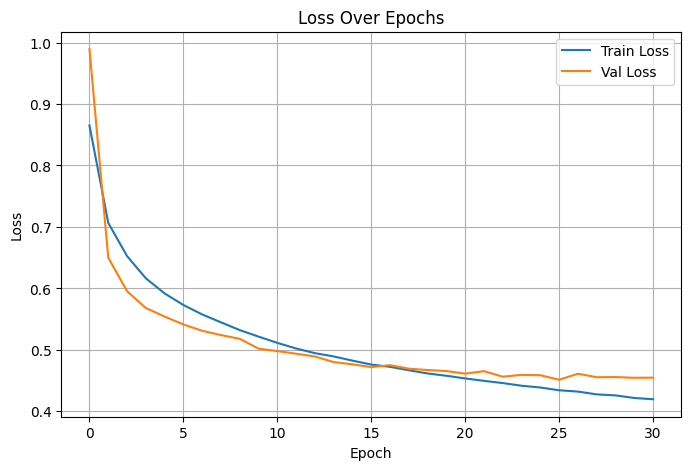

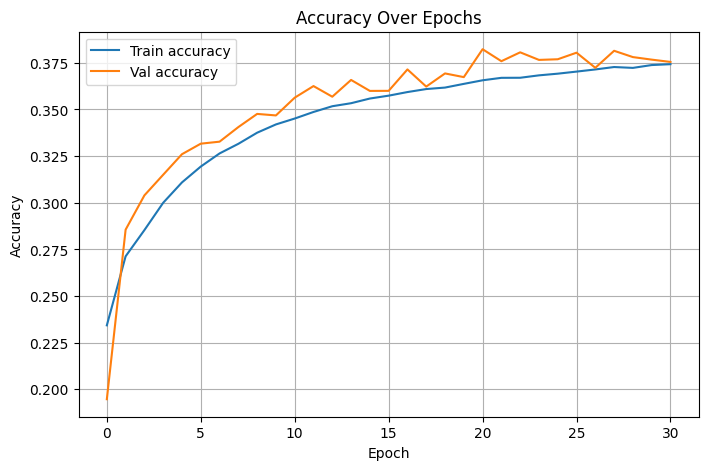

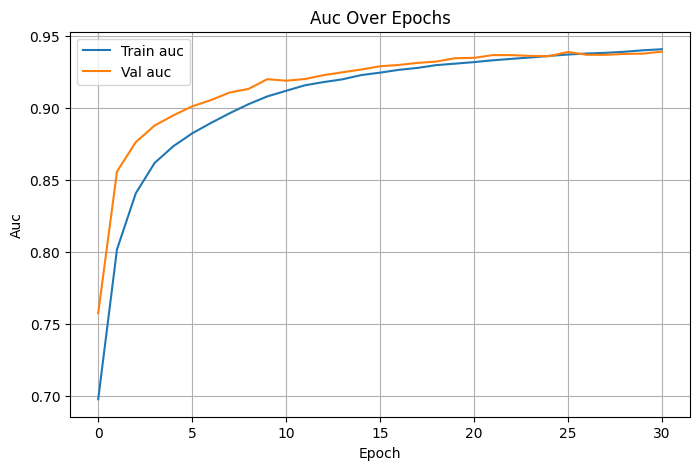

In [ ]:
plot_training_history('/content/drive/MyDrive/AC209B/MODELS/hybrid_transformer_history.pkl')

Figure 5.6. Hybrid CNN transformer model loss, accuracy, and AUC values by epoch, stratified by training and validation cohorts.

# Model Evaluation and Results

After performing exploratory data analysis (EDA), we withheld a dedicated test set that was never seen during training or validation. We used this set to objectively evaluate the performance of all models. The results are summarized below:

In [ ]:
#test set
!cp /content/drive/MyDrive/AC209B/PROCESSED_DATA/Standard_Multilabel/ecg_standard_multilabel_test_TFR.zip /content/
!unzip /content/ecg_standard_multilabel_test_TFR.zip

Archive:  /content/ecg_standard_multilabel_test_TFR.zip
replace upload/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/upload/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
  inflating: upload/standard ecg test.tfrecord  
  inflating: __MACOSX/upload/._standard ecg test.tfrecord  


In [ ]:
!mv "/content/upload/standard ecg test.tfrecord" /content/upload/test.tfrecord
TEST_TFRECORD = '/content/upload/test.tfrecord'

In [ ]:
test_ds=make_tfrecord_dataset(TEST_TFRECORD, BATCH_SIZE, shuffle=False, repeat=False)

In [ ]:
#Load models

# Load CNN model
cnn_model= tf.keras.models.load_model(
    '/content/drive/MyDrive/AC209B/MODELS/best_standard_ecg_cnn_classifier.keras',
    custom_objects={'weighted_bce_tf': weighted_binary_crossentropy(class_weights_tf)}
)

# Load CLS-Encoder model
encoder_classifier = tf.keras.models.load_model(
    '/content/drive/MyDrive/AC209B/MODELS/enoder_classifer_best.keras',
    custom_objects={'loss_fn': weighted_binary_crossentropy(class_weights_tf)}
)


# Load CNN-LSTM model
cnn_lstm_model = tf.keras.models.load_model(
    '/content/drive/MyDrive/AC209B/MODELS/cnn_lstm_hybrid_best.keras',
    custom_objects={'loss_fn': weighted_binary_crossentropy(class_weights_tf)}
)

# Load ResNet1D model
resnet_model = tf.keras.models.load_model(
    '/content/drive/MyDrive/AC209B/MODELS/resnet1d_best.keras',
    custom_objects={'loss_fn': weighted_binary_crossentropy(class_weights_tf)}
)

# Load Transformer model
transformer_model = tf.keras.models.load_model(
    '/content/drive/MyDrive/AC209B/MODELS/ecg_transformer_best.keras',
    custom_objects={'loss_fn': weighted_binary_crossentropy(class_weights_tf)}
)

#Load Hybrid Transformer model
hybrid_transformer_model = tf.keras.models.load_model(
    '/content/drive/MyDrive/AC209B/MODELS/hybrid_transformer_best.keras',
    custom_objects={'loss_fn': weighted_binary_crossentropy(class_weights_tf)}
)


### Results

In [ ]:
# Define all models
models = {
    'CNN': cnn_model,
    'Encoder+MLP': encoder_classifier,
    'CNN-LSTM': cnn_lstm_model,
    'ResNet1D': resnet_model,
    'Transformer': transformer_model,
    'Hybrid Transformer': hybrid_transformer_model
}

# Dictionaries to store results
model_aucs = {}
model_auprcs = {}
model_baccs = {}
model_thresholds = {}
model_fpr = {}
model_tpr = {}
model_y_true = {}
model_y_pred = {}
model_y_probs = {}

# Run evaluation for each model
for name, model in models.items():
    print(f"\n=== Evaluating {name} ===")
    aucs, auprcs, baccs, thresholds, fpr_dict, tpr_dict, y_true, y_pred, y_probs = evaluate_model(model, test_ds, LABEL_COLUMNS)

    model_aucs[name] = aucs
    model_auprcs[name] = auprcs
    model_baccs[name] = baccs
    model_thresholds[name] = thresholds
    model_fpr[name] = fpr_dict
    model_tpr[name] = tpr_dict
    model_y_true[name] = y_true
    model_y_pred[name] = y_pred
    model_y_probs[name] = y_probs


=== Evaluating CNN ===
Afib                 AUC: 0.9476  AUPRC: 0.6625  BAcc: 0.8216  Thresh: 0.07
Aflutter             AUC: 0.9103  AUPRC: 0.3419  BAcc: 0.6696  Thresh: 0.14
Left_axis            AUC: 0.9630  AUPRC: 0.7578  BAcc: 0.8884  Thresh: 0.17
Right_axis           AUC: 0.9827  AUPRC: 0.6413  BAcc: 0.8201  Thresh: 0.11
RBBB                 AUC: 0.9881  AUPRC: 0.9086  BAcc: 0.9049  Thresh: 0.40
LBBB                 AUC: 0.9856  AUPRC: 0.8470  BAcc: 0.8636  Thresh: 0.37
LAFB                 AUC: 0.9806  AUPRC: 0.7476  BAcc: 0.8692  Thresh: 0.15
First_Degree_AVB     AUC: 0.8577  AUPRC: 0.3384  BAcc: 0.7092  Thresh: 0.22
LVH                  AUC: 0.9331  AUPRC: 0.6714  BAcc: 0.7961  Thresh: 0.06
RVH                  AUC: 0.9430  AUPRC: 0.2524  BAcc: 0.6638  Thresh: 0.07
LAE                  AUC: 0.8992  AUPRC: 0.5059  BAcc: 0.7451  Thresh: 0.09
RAE                  AUC: 0.8917  AUPRC: 0.0664  BAcc: 0.5593  Thresh: 0.02
Final_Ischemia       AUC: 0.8711  AUPRC: 0.8159  BAcc: 0.7882  T

Summary table of per-class performance metrics (AUC, AUPRC, Balanced Accuracy, and optimal threshold) for all six models evaluated on the withheld test set. Across most classes, deep CNN-based architectures (e.g., CNN-LSTM, ResNet1D, Hybrid Transformer) consistently achieve high AUC and balanced accuracy, particularly for structural abnormalities such as RBBB, LBBB, and axis deviations. In contrast, performance drops noticeably for classes with fewer or noisier samples, such as RAE and PAC, as seen in lower AUPRC and balanced accuracy. These results underscore the varying difficulty of arrhythmia classification tasks and highlight the robustness of certain architectures for specific ECG features.

### ROC Curves Per Model

In [ ]:
def plot_roc_per_model(model_fpr, model_tpr, model_names=()):
    for name in model_fpr:
        plt.figure(figsize=(10, 6))
        for label in LABEL_COLUMNS:
            fpr = model_fpr[name].get(label)
            tpr = model_tpr[name].get(label)
            if fpr is not None and tpr is not None:
                plt.plot(fpr, tpr, label=label)
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.title(f'ROC Curves - {name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right', fontsize='small')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

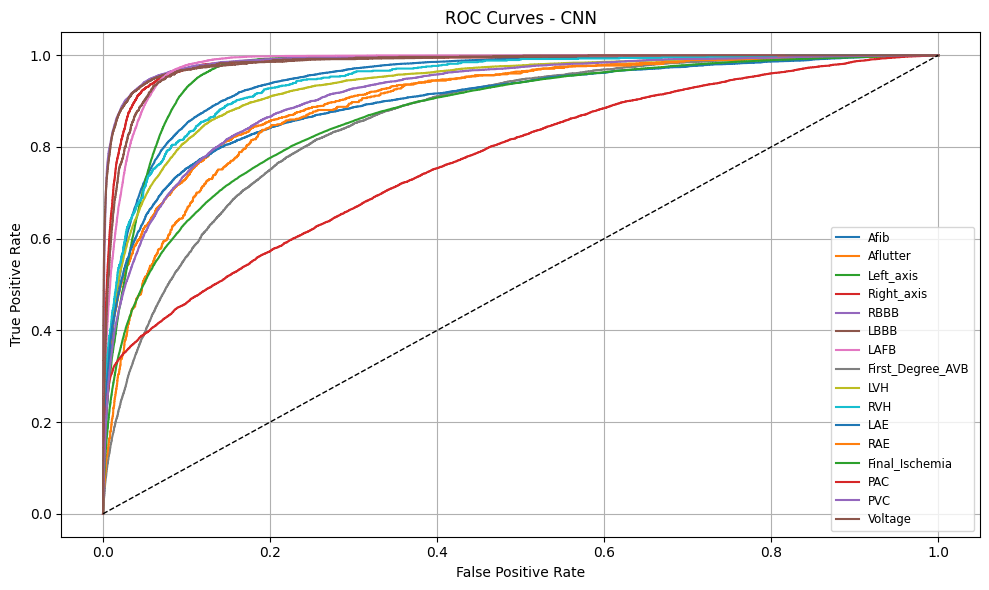

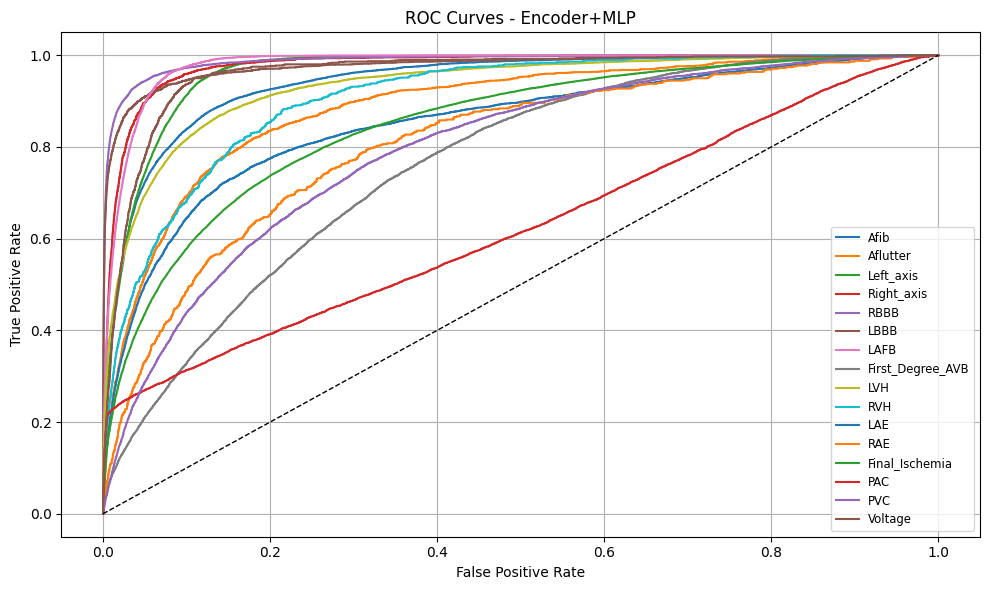

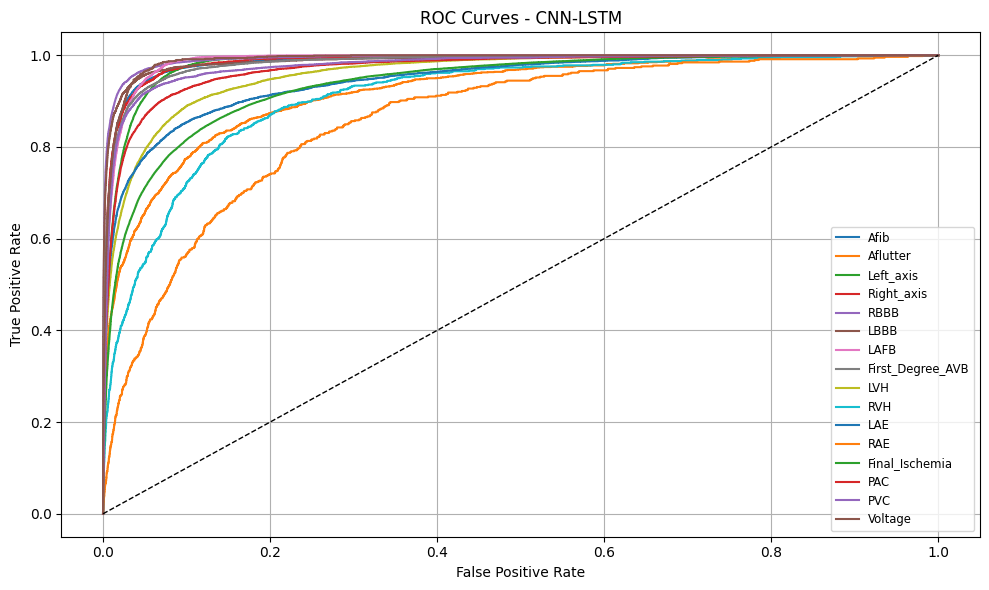

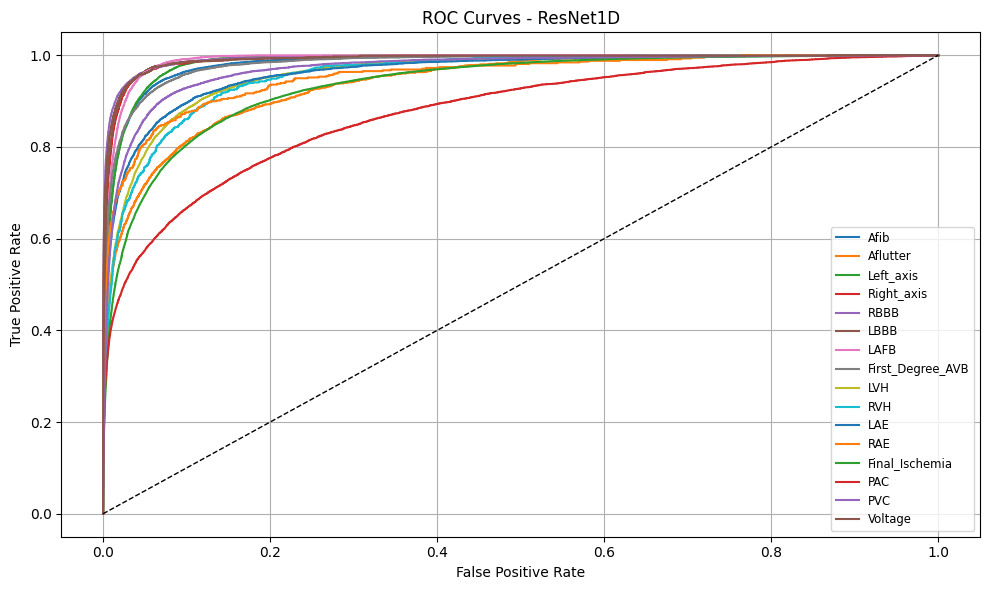

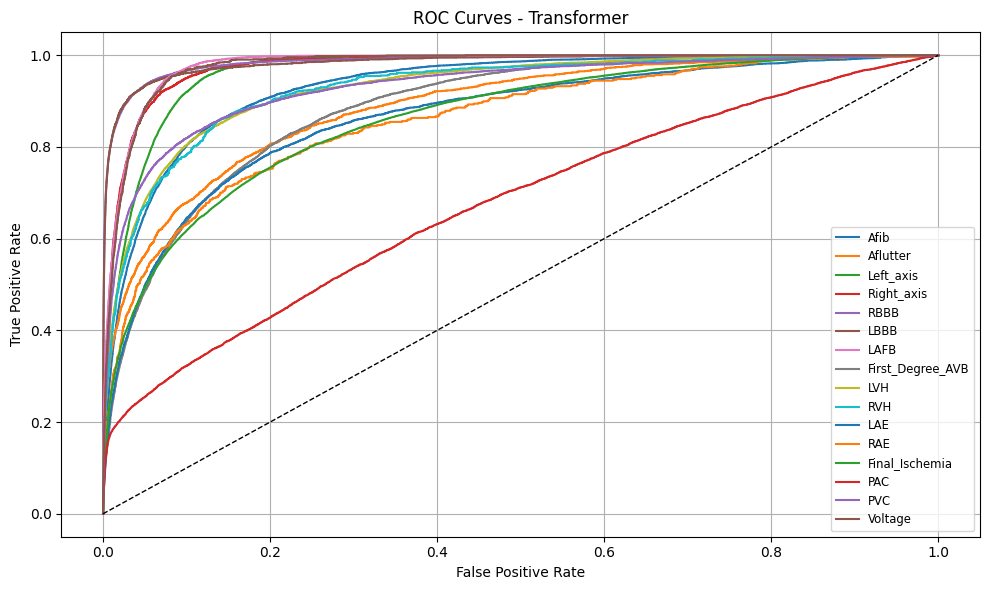

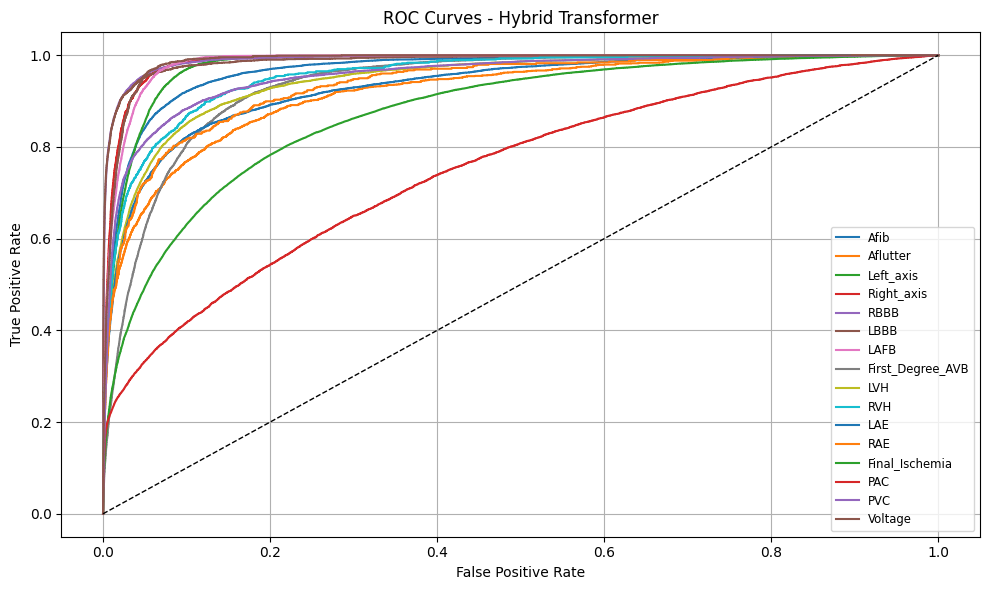

In [ ]:
plot_roc_per_model(model_fpr, model_tpr)

Figure 6. Across all models- CNN-LSTM, ResNet1D show the strongest ROC performance, with ResNet1D performing particularly well across most classes. The curves are steep and consistent, indicating the model effectively balances sensitivity and specificity, even for harder classes like RAE and PAC, which maintain decent curve shapes. The Transformer-only model clearly underperforms, with noticeably flatter curves for several classes, but the Hybrid Transformer regains much of that lost performance by incorporating local convolutional features. Overall, models that include convolutional components show the most reliable performance across both common and rare ECG abnormalities.


### Precision - Recall Curves Per Model

In [ ]:
def plot_prc_per_model(model_y_true, model_y_probs):
    for name in model_y_true:
        plt.figure(figsize=(10, 6))
        for i, label in enumerate(LABEL_COLUMNS):
            try:
                precision, recall, _ = precision_recall_curve(model_y_true[name][:, i], model_y_probs[name][:, i])
                plt.plot(recall, precision, label=label)
            except:
                continue
        plt.title(f'Precision-Recall Curves - {name}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='lower left', fontsize='small')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

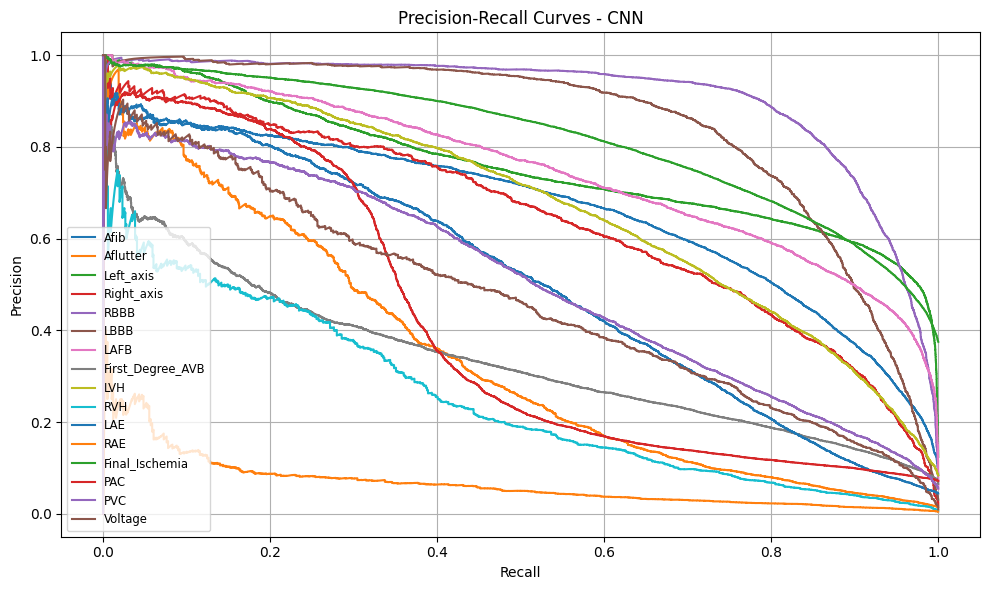

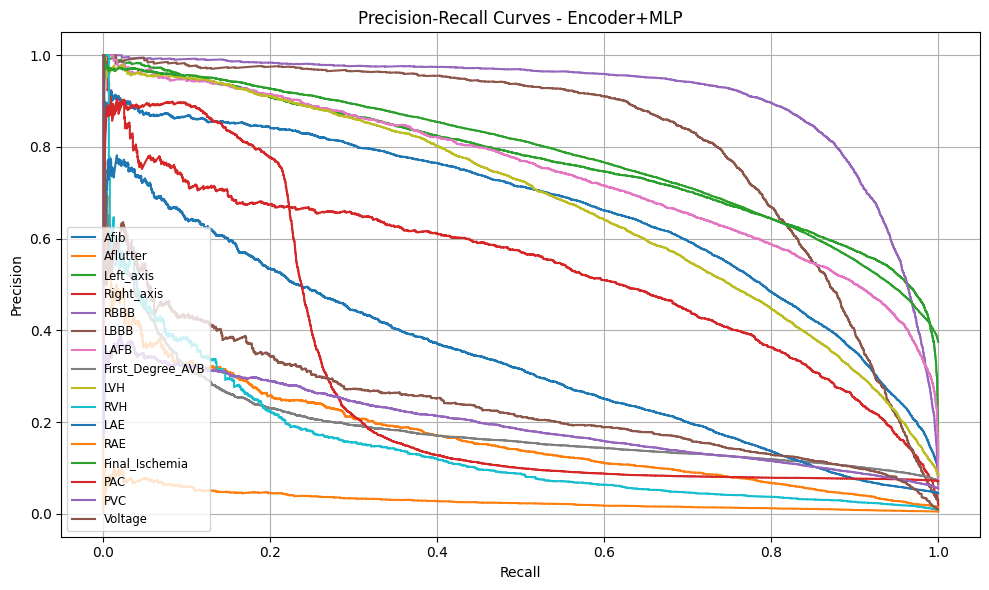

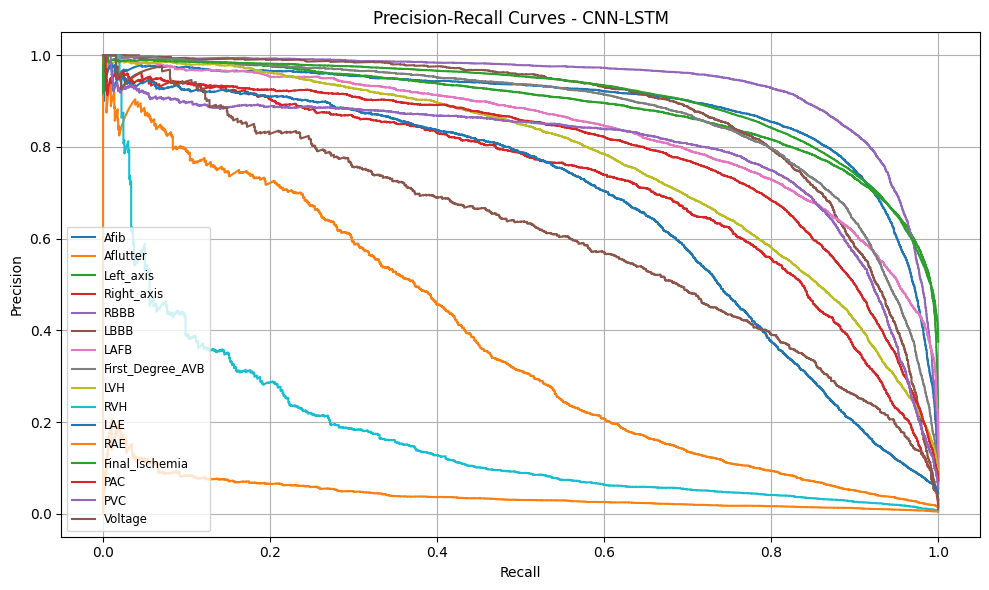

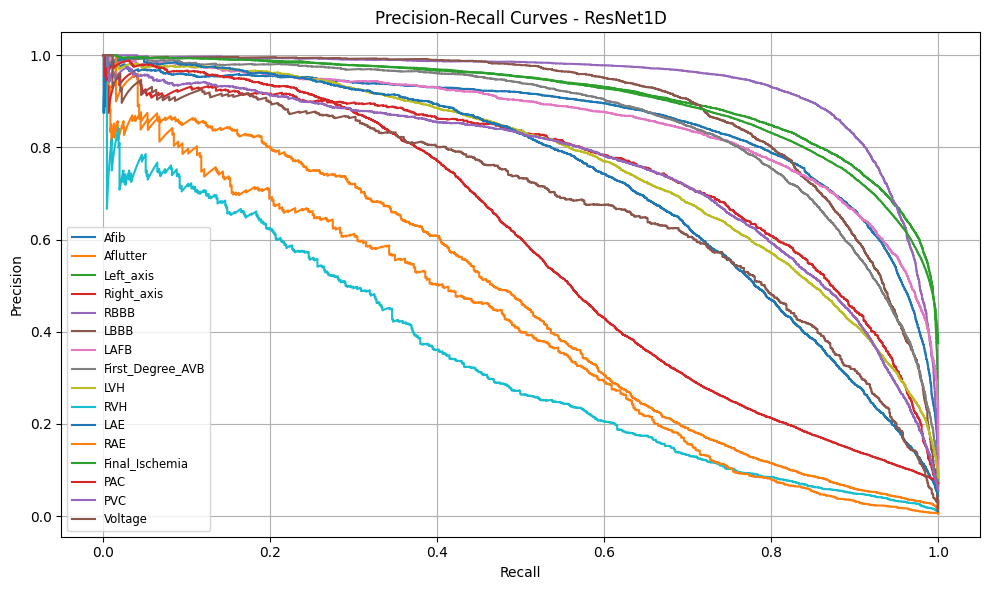

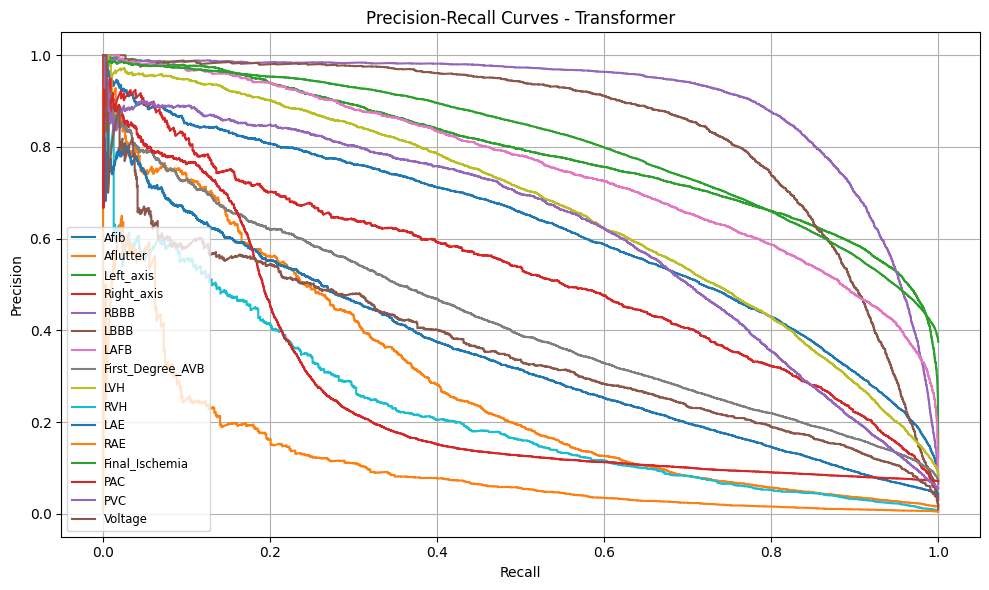

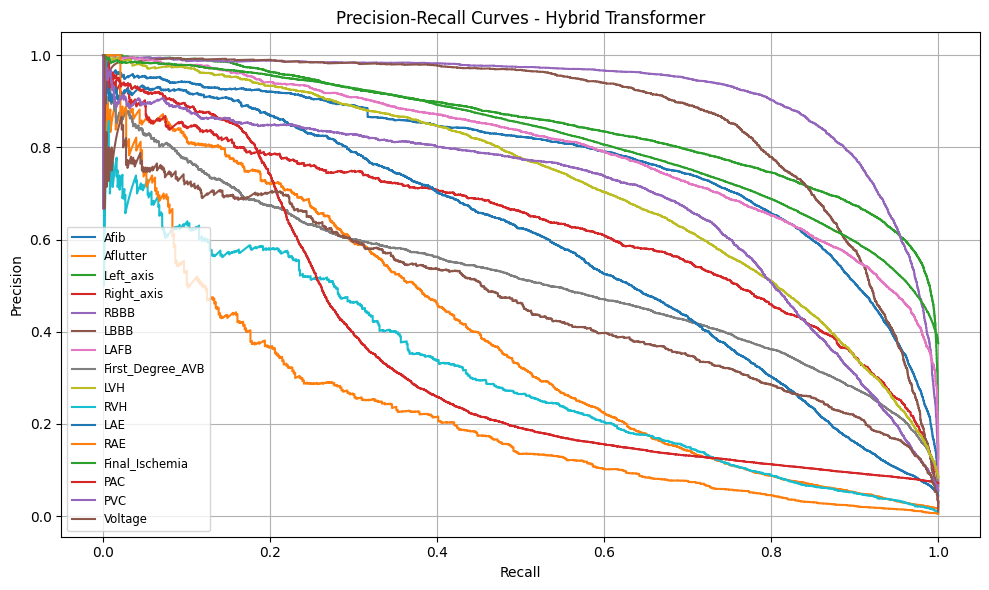

In [ ]:
plot_prc_per_model(model_y_true, model_y_probs)

Figure 7. AUPRC cure for all models.
We can see that overall ResNet1D has the most consistent and elevated precision-recall curves, meaning there's strong performance in both identifying positive cases and avoiding false positives. The CNN models perform well on several labels but shows more drop-off in precision at high recall levels, especially for rare classes like PAC, RAE, and RVH. The Transformer model struggles the most, with flatter curves across multiple labels, reflecting its difficulty in maintaining precision as recall increases. The Hybrid Transformer improves upon the base Transformer, especially for waveform-dominant classes like PVC and LBBB, but still trails other CNN-based architectures overall. RAE and PAC remain the most challenging classes, showing steep declines in precision across all models, highlighting ongoing difficulty in detecting these subtle and underrepresented rhythms.


### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrices_all(model_y_true, model_y_pred):
    for name in model_y_true:
        fig, axes = plt.subplots(4, 4, figsize=(16, 14))
        fig.suptitle(f'Confusion Matrices - {name}', fontsize=16)

        for i, label in enumerate(LABEL_COLUMNS):
            row, col = divmod(i, 4)
            ax = axes[row][col]
            cm = confusion_matrix(model_y_true[name][:, i], model_y_pred[name][:, i])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
            ax.set_title(label, fontsize=10)
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')

        plt.tight_layout(rect=[0, 0, 1, 0.97])  # leave space for suptitle
        plt.show()

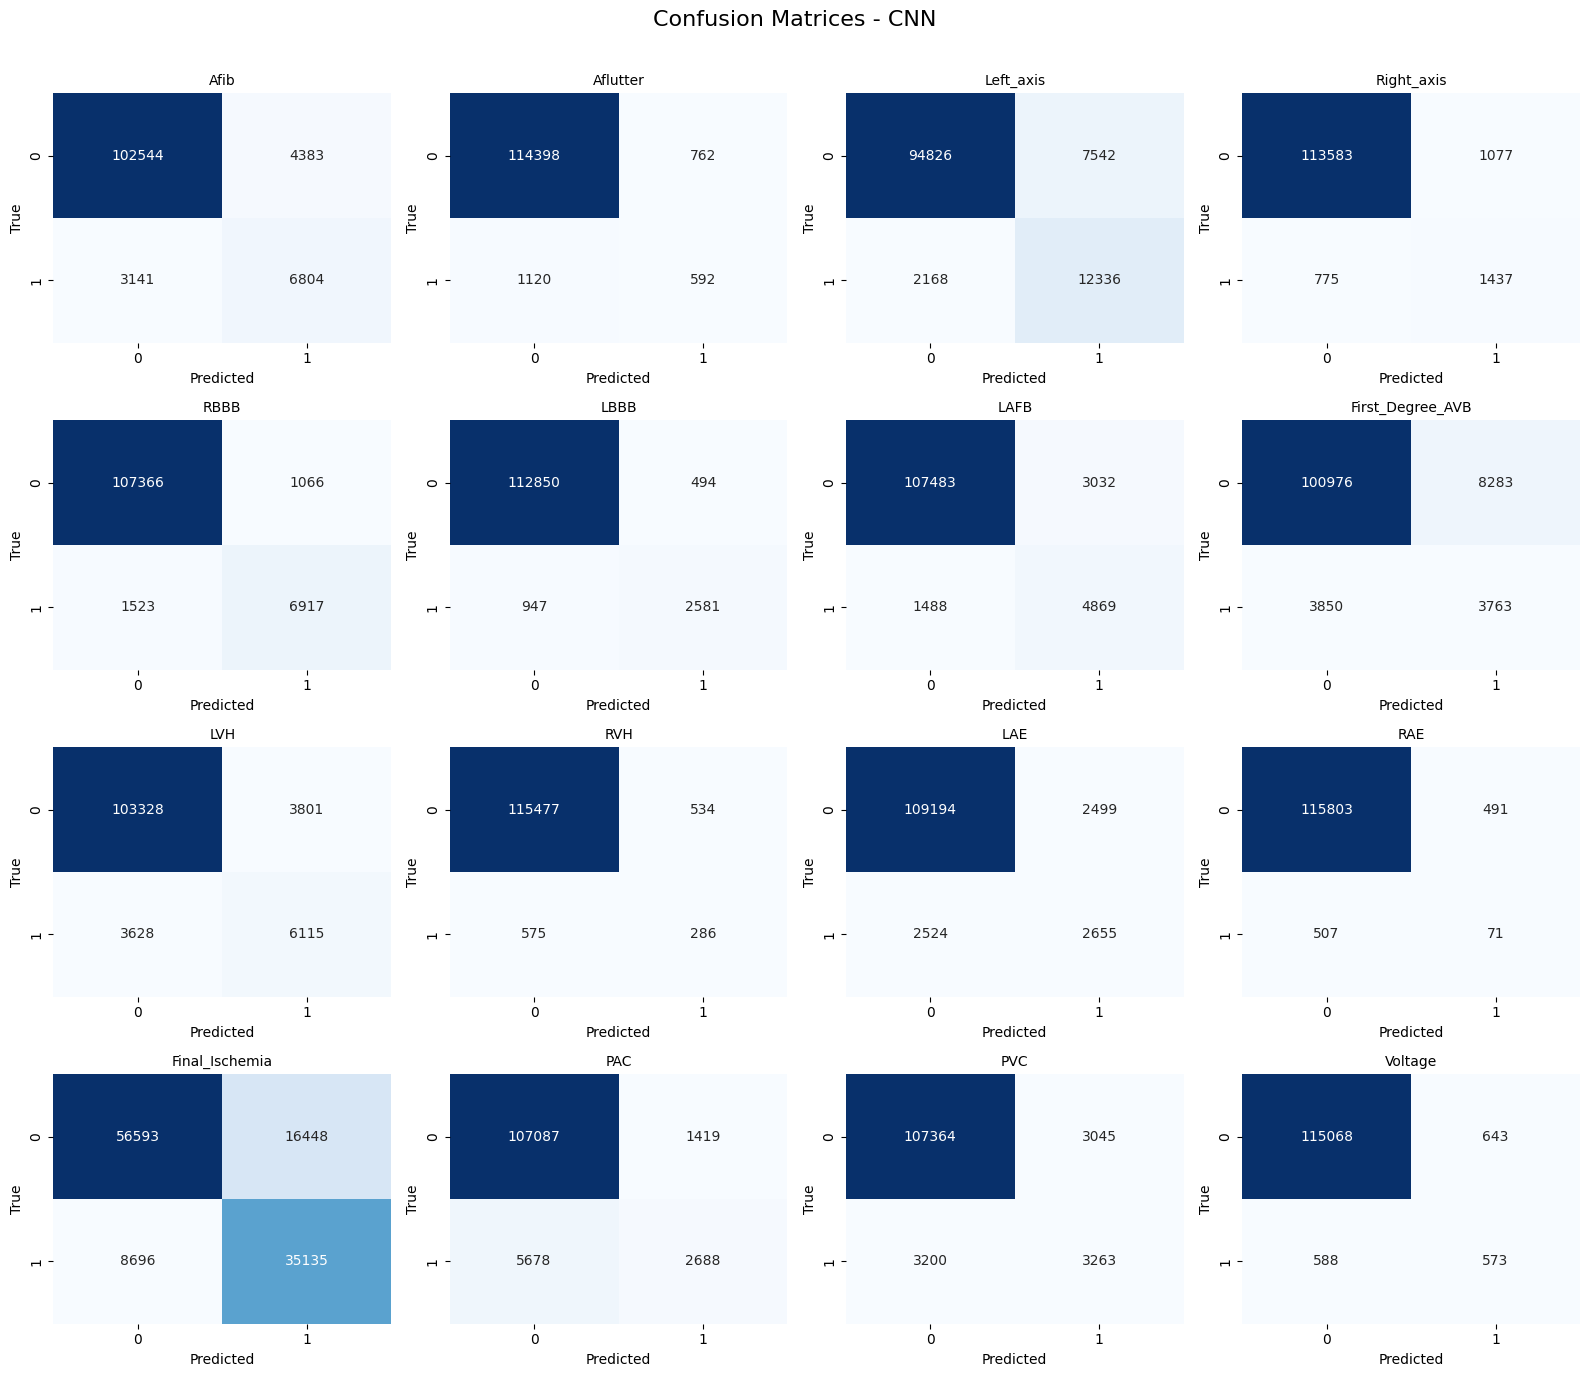

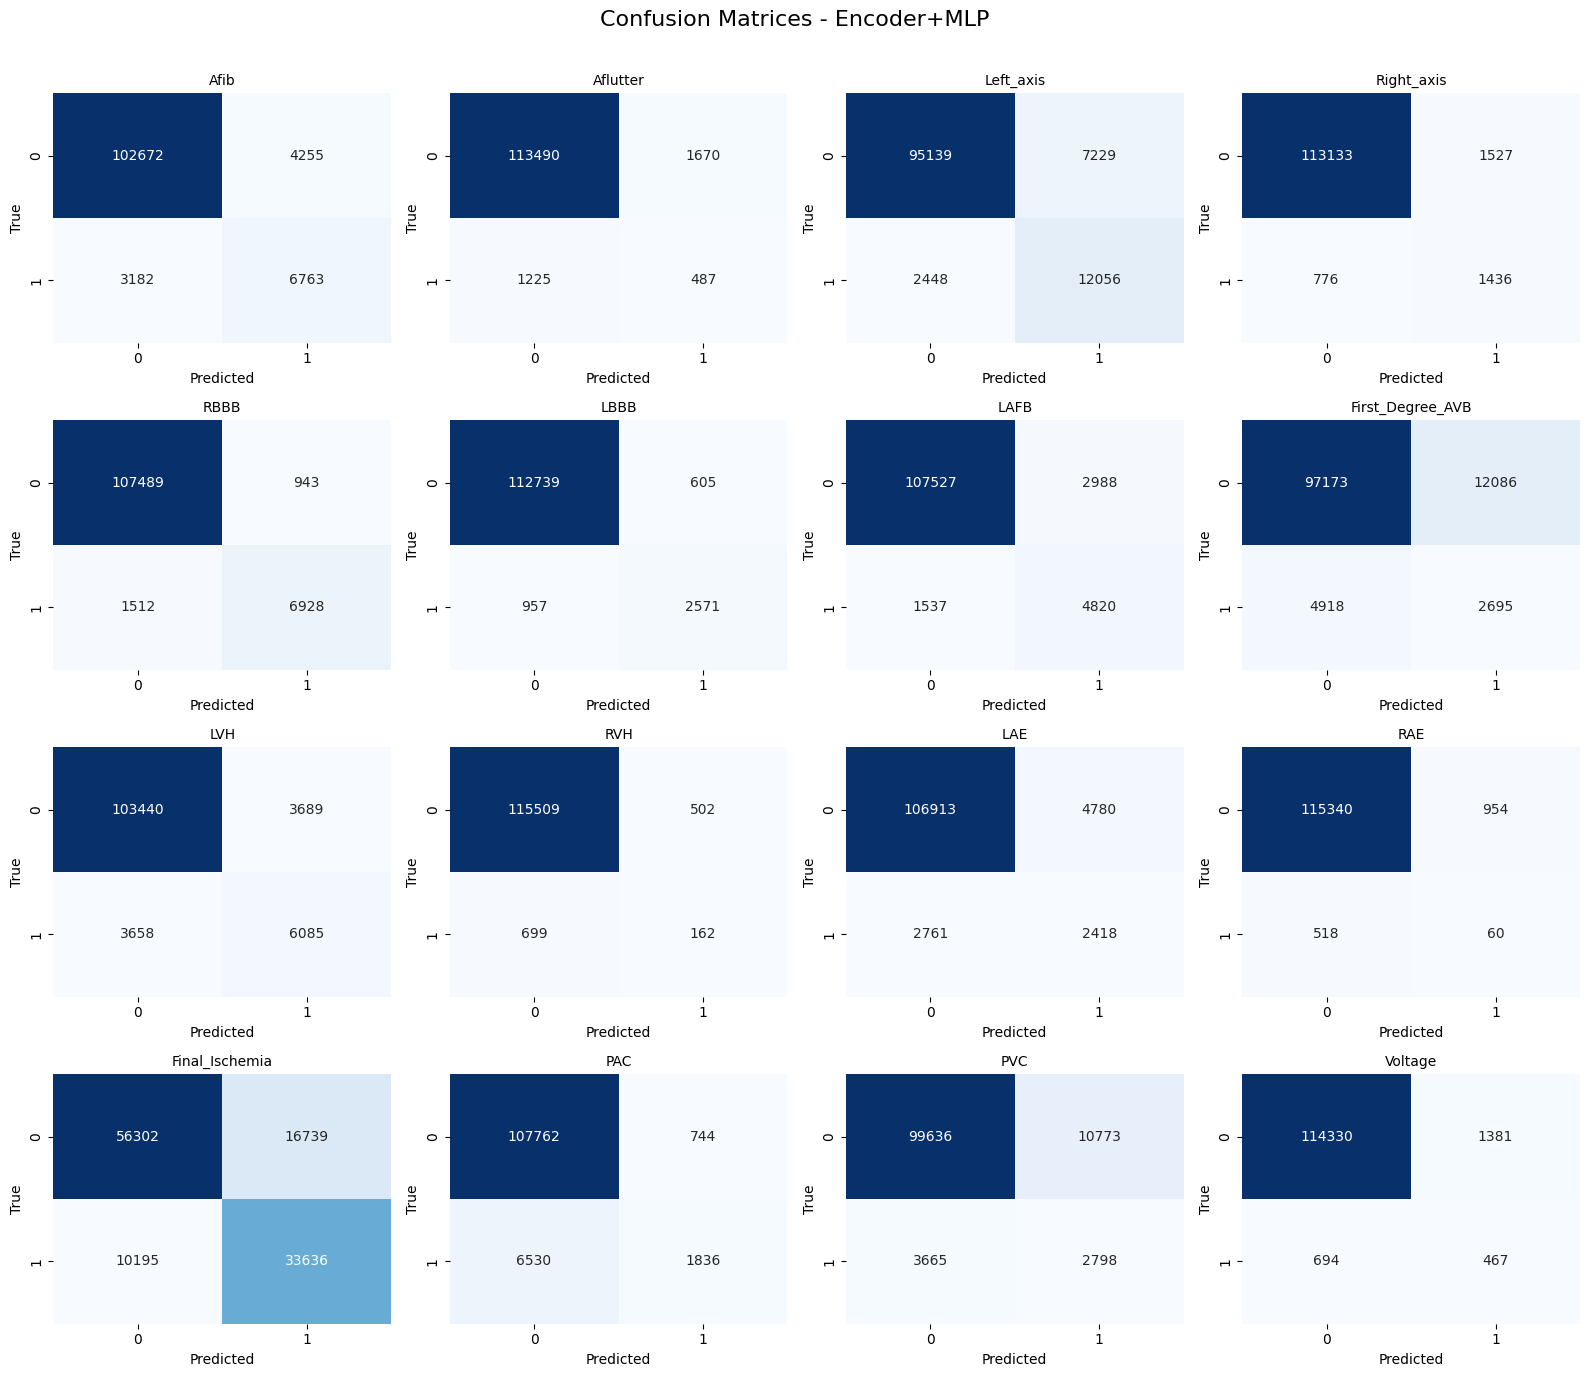

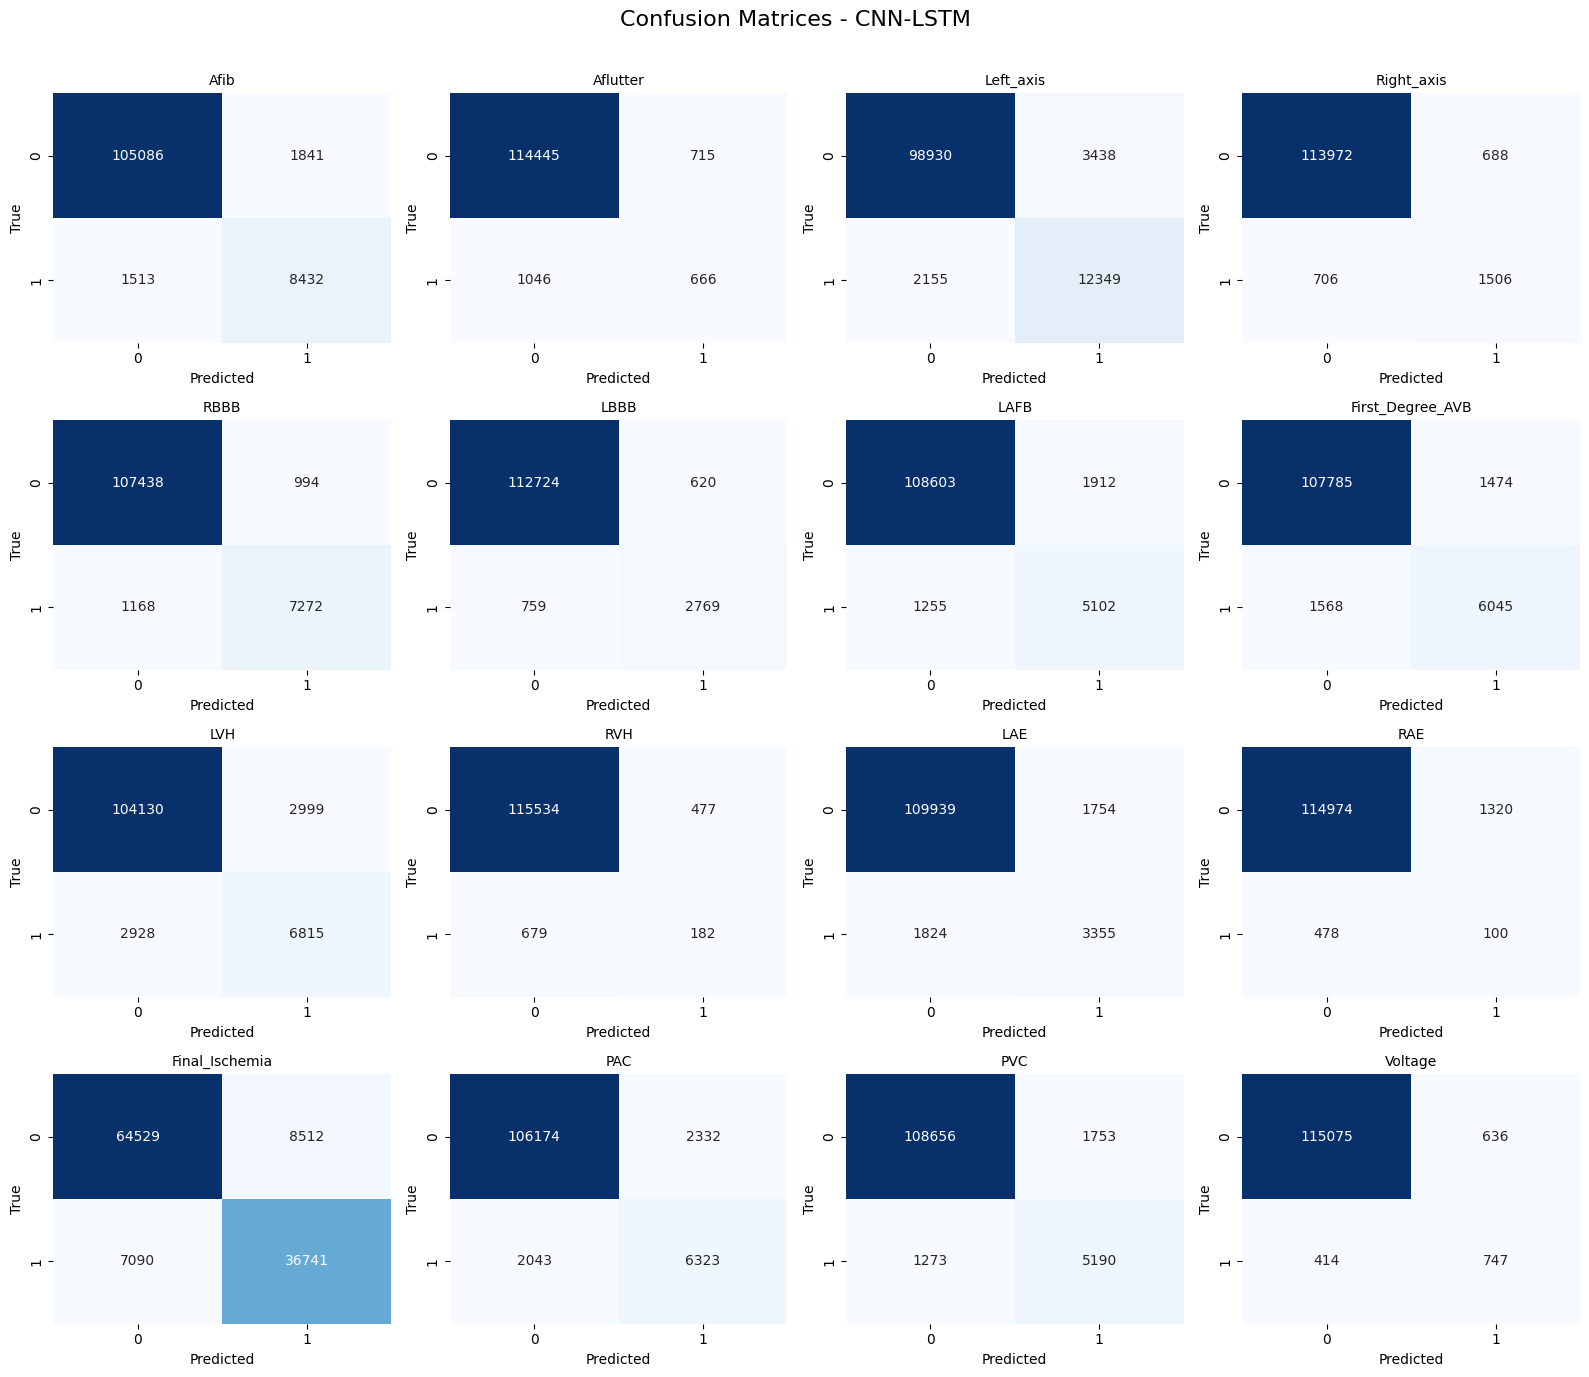

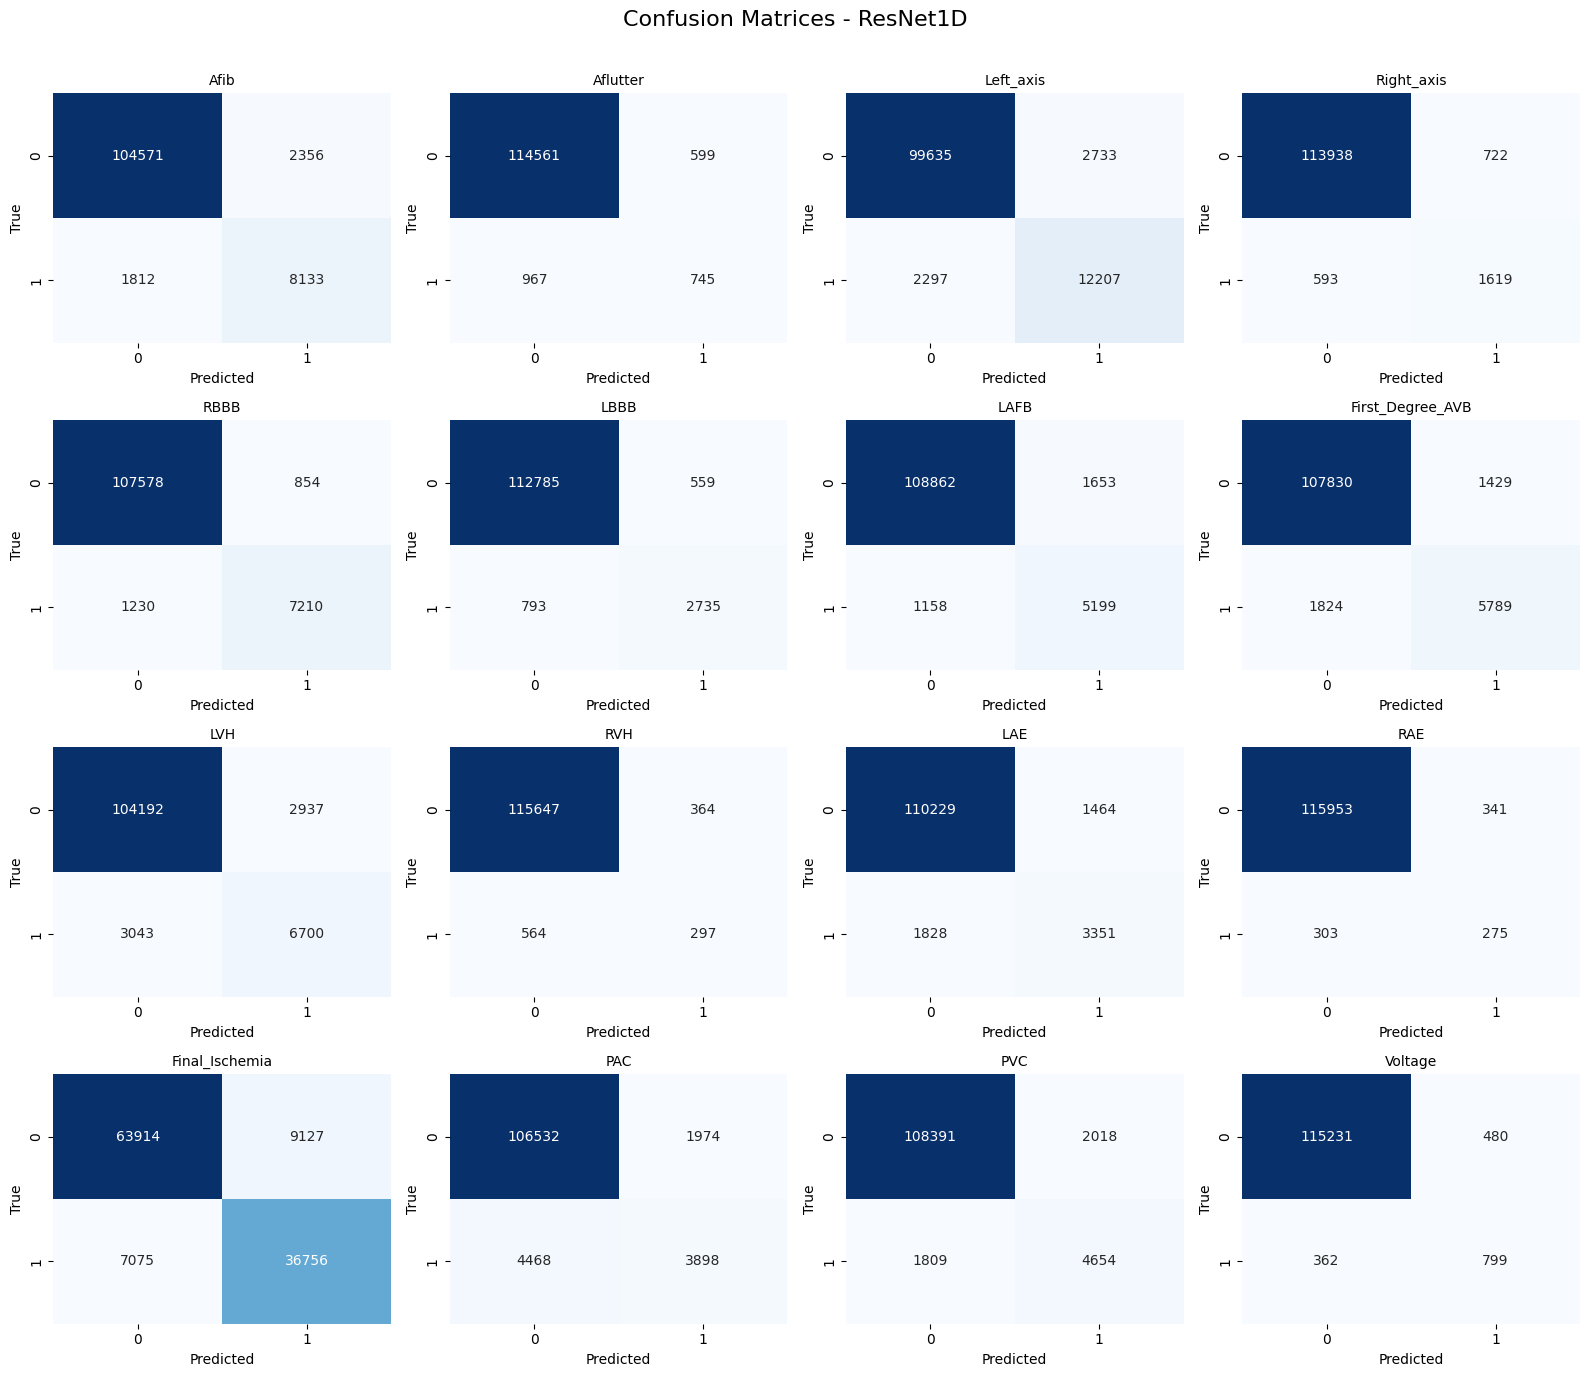

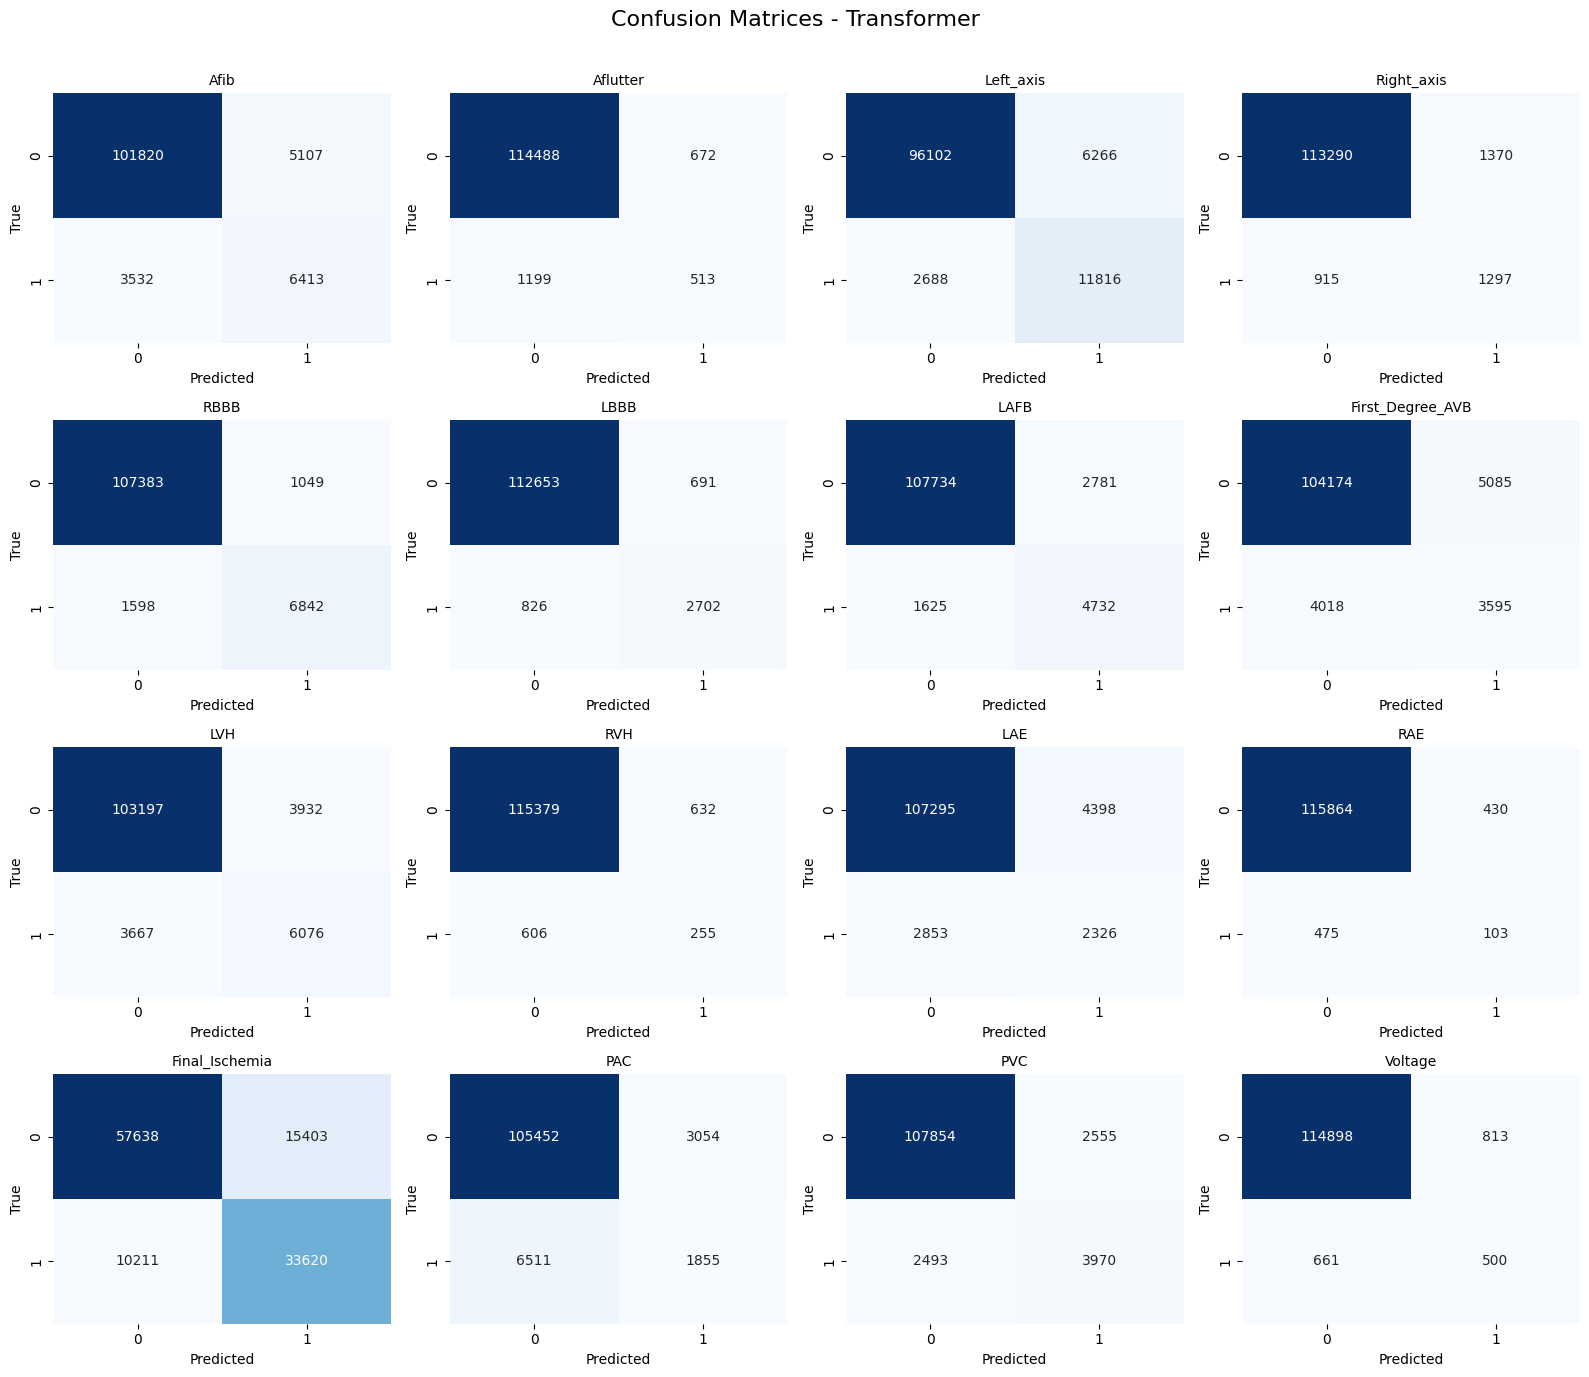

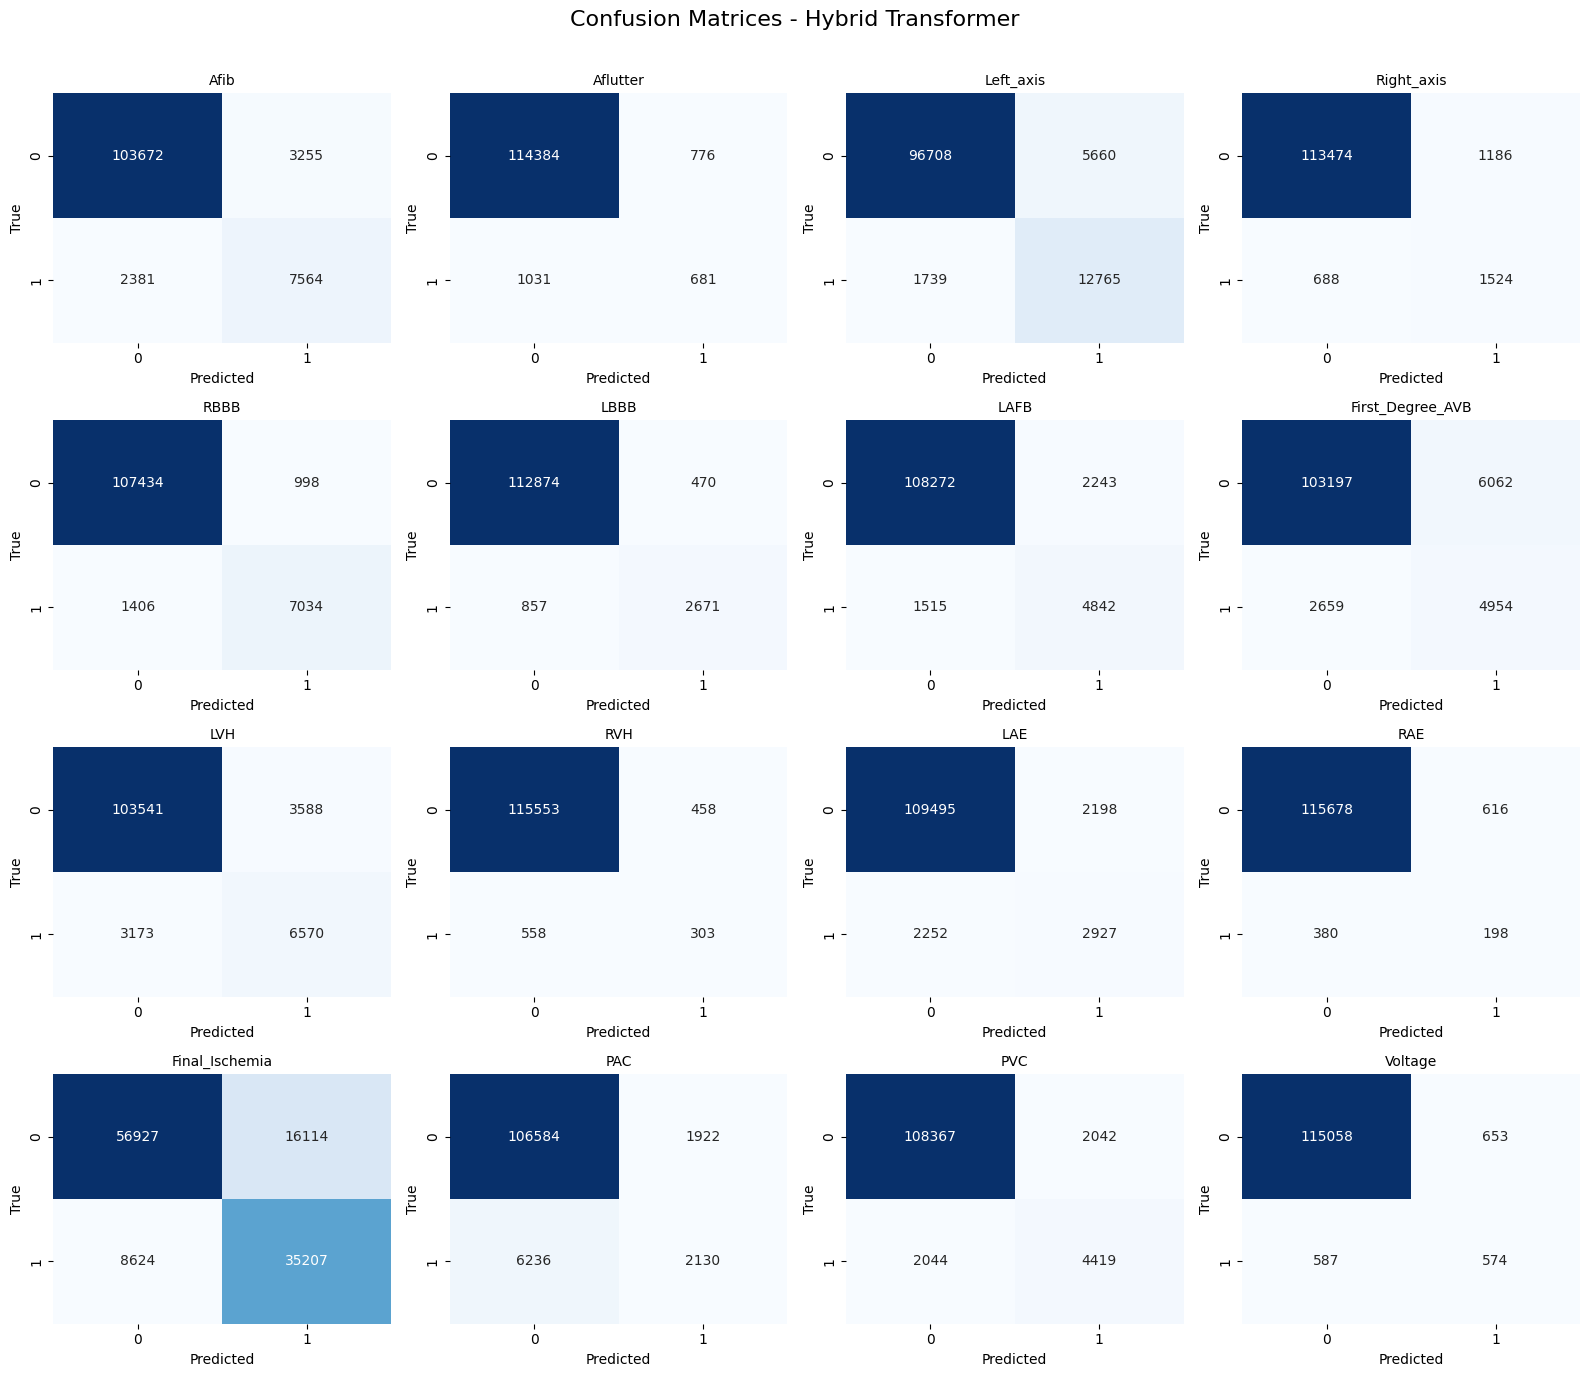

In [ ]:
plot_confusion_matrices_all(model_y_true, model_y_pred)

Figure 8. Confusion Matrices of all models. Across models, the true negative (top-left) counts dominate, which is expected due to class imbalance. CNN-LSTM and ResNet1D show consistently strong performance with low false positives and high true positives, especially for challenging classes like Afib, RBBB, and Final_Ischemia. The Transformer model shows a drop in sensitivity for many classes — with lower true positives and higher false negatives — confirming what was seen in the ROC and PR curves. The Hybrid Transformer recovers some of this, with improvements in classes like LBBB, PVC, and Voltage, but still trails convolutional models in recall for rarer classes like RAE and PAC. Overall, ResNet1D offers the most balanced confusion patterns, indicating strong generalization across both common and rare ECG abnormalities.

In [ ]:
def plot_per_class_metric(metric_dict, label_names, metric_name='AUPRC'):
    models = list(metric_dict.keys())
    n_classes = len(label_names)
    x = np.arange(n_classes)
    width = 0.12

    plt.figure(figsize=(15, 6))
    for i, model in enumerate(models):
        plt.bar(x + i * width, metric_dict[model], width, label=model)

    plt.xticks(x + width * (len(models)-1) / 2, label_names, rotation=45, ha='right')
    plt.ylabel(metric_name)
    plt.title(f'Per-Class {metric_name} by Model')
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

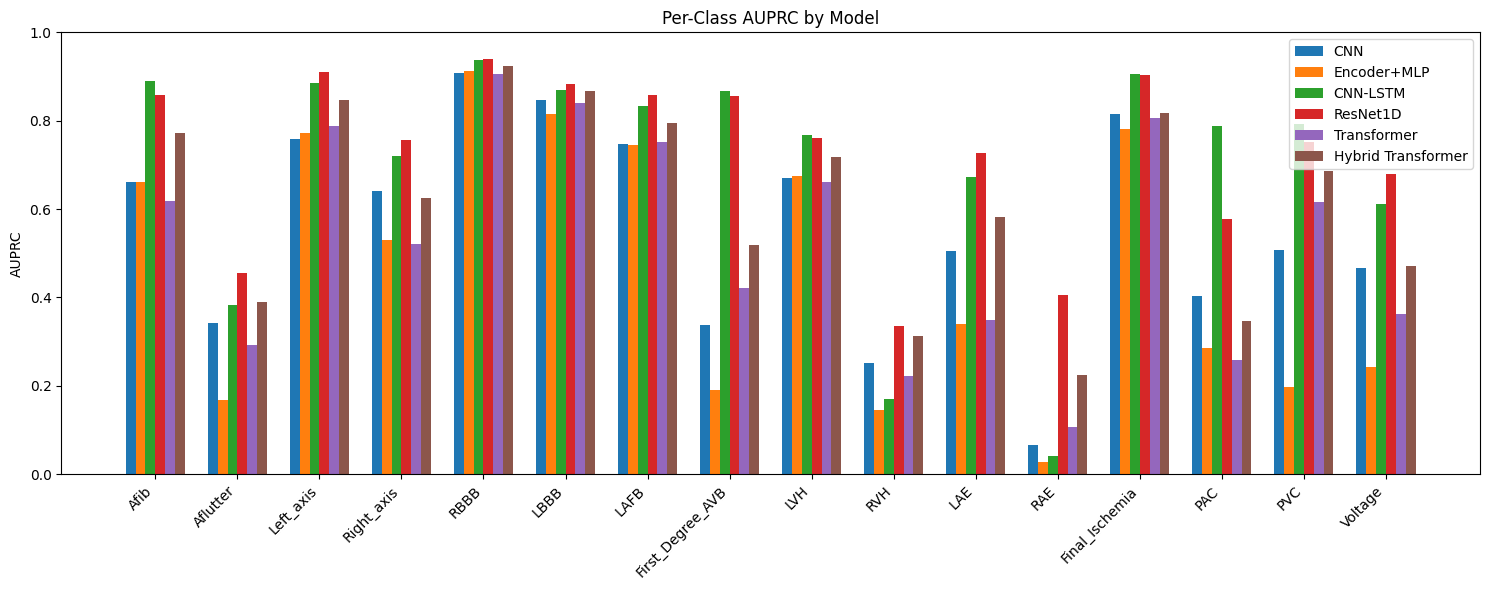

In [ ]:
plot_per_class_metric(model_auprcs, LABEL_COLUMNS, metric_name='AUPRC')

Figure 9. AUPRC per class of all the models. We can see that there's quite a bit of variation across classes with all most models performing well on more common classes, and not performing so well on the rarer classes. For the most case Resnet1D and CNN-LSTM models tend to perform better than other models.

In [ ]:
def plot_average_metrics(aucs, auprcs, baccs):
    models = list(aucs.keys())
    metrics = ['Mean AUC', 'Mean AUPRC', 'Mean BAcc']
    values = [
        [np.nanmean(aucs[m]) for m in models],
        [np.nanmean(auprcs[m]) for m in models],
        [np.nanmean(baccs[m]) for m in models],
    ]

    x = np.arange(len(models))
    width = 0.25

    plt.figure(figsize=(10, 5))
    for i, metric in enumerate(metrics):
        plt.bar(x + i * width, values[i], width, label=metric)

    plt.xticks(x + width, models)
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title("Average Metrics per Model")
    plt.legend()
    plt.tight_layout()
    plt.show()

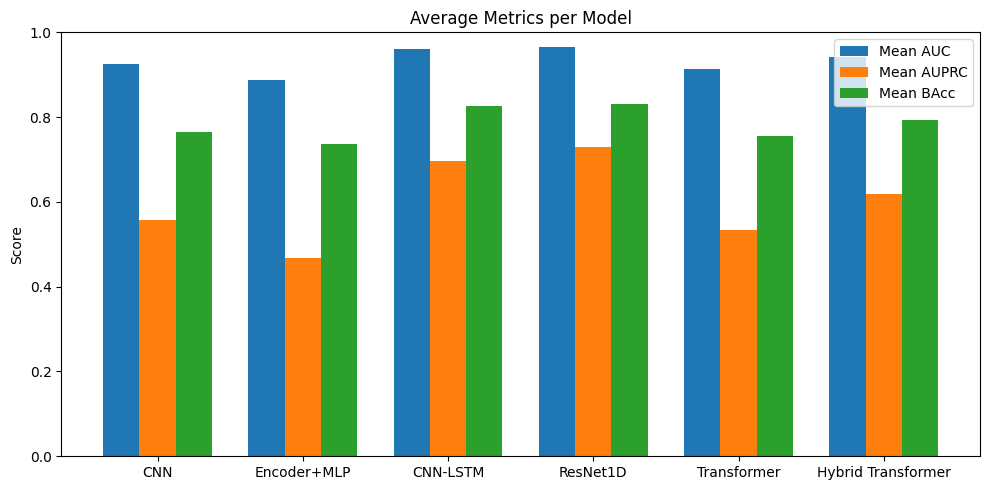

In [ ]:
plot_average_metrics(model_aucs, model_auprcs, model_baccs)

Figure 10. Average metrics (AUC, AUPRC, and balanced accuracy) all models. Most models have a pretty high average AUC but CNN-LSTM and ResNet1D have the highest average balanced accuracy, mean AUPRC score.

# Conclusions

In conclusion, architectures combining local feature extraction with deep contextual modeling, particularly ResNet1D, delivered the strongest overall performance across AUC, AUPRC, and balanced accuracy. The residual connections in ResNet1D improved training stability and enabled the model to capture both local patterns such as the detailed waveform features and also global contextual patterns in the ECG sequence.

While the CNN-LSTM model performed better on certain classes, especially those with strong temporal dependencies such as prematrue atrial complex (PAC), ResNet1D showed more consistent results across the majority of conditions. Transformer-based models underperformed, and although the hybrid transformer model improved over the base version, it still did not match the performance of the simpler residual architecture.

For multilabel ECG diagnosis on an imbalanced dataset, ResNet1D offered the best balance of generalization and robustness, making it our recommended final model. A simplified flowchart of the architecture is shown below.

## Final Selected Model Architecture Flowchart

ResNet1D Architecture



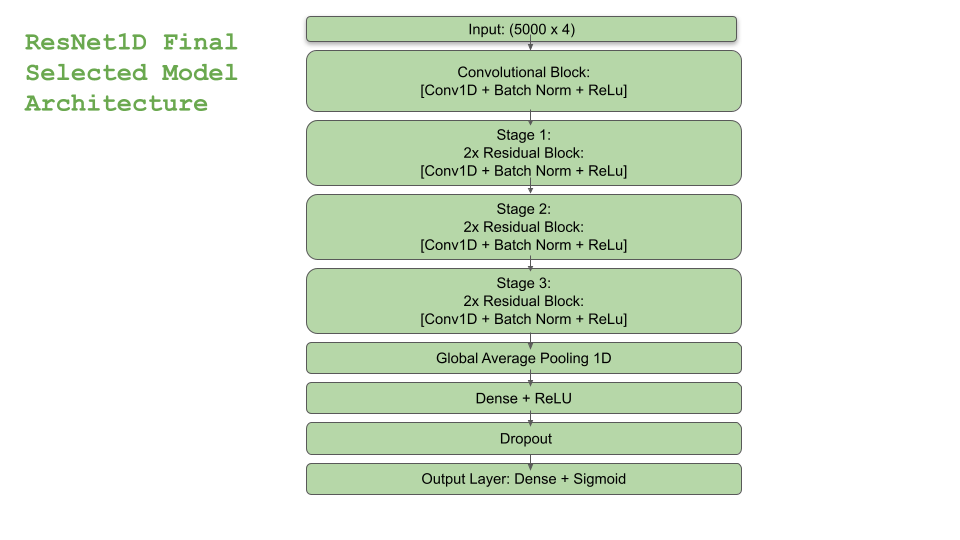

# Future Directions

Future work could explore CLIP-inspired self-supervised learning approaches that align paired waveforms and raw reports within a shared latent space. Expanding the training datasets to include more diverse patient populations would enhance the model’s generalizability. Another potential direction is the incorporation of an LLM API to generate realistic ECG reports from model outputs. Further research may also focus on fine-tuning the model for tasks such as predicting rare genetic syndromes or stratifying risk among hospitalized patients with cardiac conditions.

# References

1. Drazen E, Mann N, Borun R, Laks M, Bersen A. Survey of computer-assisted electrocardiography in the United States. J Electrocardiol. 1988;21:S98-S104. doi:10.1016/0022-0736(88)90068-4
2. Kashou AH, Noseworthy PA, Beckman TJ, et al. ECG Interpretation Proficiency of Healthcare Professionals. Curr Probl Cardiol. 2023;48(10):101924. doi:10.1016/j.cpcardiol.2023.101924
3. Cook DA, Oh SY, Pusic MV. Accuracy of Physicians’ Electrocardiogram Interpretations: A Systematic Review and Meta-analysis. JAMA Intern Med. 2020;180(11):1461-1471. doi:10.1001/jamainternmed.2020.3989
4. McKeen, K., Oliva, L., Masood, S., Toma, A., Rubin, B. and Wang, B.
McKeen, K., Oliva, L., Masood, S., Toma, A., Rubin, B., & Wang, B. (2024). ECG-FM: An Open Electrocardiogram Foundation Model. Retrieved from https://arxiv.org/abs/2408.05178
